PI-MAE 90% Physical Mask

In [1]:
!pip install tensorflow_addons

In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

SEED = 42
keras.utils.set_random_seed(SEED)

from keras import backend
backend.set_image_data_format('channels_last') #channels_first for NCHW

tf.config.run_functions_eagerly(True)

2024-03-29 15:23:41.992521: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 15:23:42.038961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 15:23:42.038987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 15:23:42.040150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 15:23:42.047279: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict'

In [4]:
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50
IMAGE_SIZE = 48
PATCH_SIZE = 3
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.90
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)

x_train_32x32 = []
for idx, train in enumerate(x_train):
    x_train_32x32.append(
        np.pad(train, pad_width=((2, 2), (2, 2)), mode='constant')
    )
x_train = np.array(x_train_32x32)

x_test_32x32 = []
for idx, test in enumerate(x_test):
    x_test_32x32.append(
        np.pad(test, pad_width=((2, 2), (2, 2)), mode='constant')
    )
x_test = np.array(x_test_32x32)

x_val_32x32 = []
for idx, val in enumerate(x_val):
    x_val_32x32.append(
        np.pad(val, pad_width=((2, 2), (2, 2)), mode='constant')
    )
x_val = np.array(x_val_32x32)

x_train = np.expand_dims(x_train, -1)
y_train = np.expand_dims(y_train, -1)

x_test = np.expand_dims(x_test, -1)
y_test = np.expand_dims(y_test, -1)

x_val = np.expand_dims(x_val, -1)
y_val = np.expand_dims(y_val, -1)

x_train = tf.image.grayscale_to_rgb(
tf.convert_to_tensor(x_train),
name=None
)

x_test = tf.image.grayscale_to_rgb(
tf.convert_to_tensor(x_test),
name=None
)

x_val = tf.image.grayscale_to_rgb(
tf.convert_to_tensor(x_val),
name=None
)

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

2024-03-29 15:23:47.295829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-29 15:23:47.346821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-29 15:23:47.350860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, interpolation='area'),],
        name="test_data_augmentation",
    )
    return model

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()
        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        plt.title('reconstructed')
        plt.imshow(reconstructed, cmap='gray')
        plt.show()
        return reconstructed

    def reconstruct_from_patch_and_find_dark_spots_batch(self, patch):
        unmask, mask = [], []
        for idx in range(patch.shape[0]):
            num_patches = patch[idx].shape[0]
            n = int(np.sqrt(num_patches))
            print('n', n)
            p = tf.reshape(patch[idx], (num_patches, self.patch_size, self.patch_size, 3))
            rows = tf.split(p, n, axis=0)
            rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
            reconstructed = tf.concat(rows, axis=0)
            reconstructed = reconstructed.numpy()
            sum_patches = []
            for idx, elem in enumerate(p):
                sum_patches.append(np.sum(elem.numpy()))
            mean_patches_indices = np.argsort(sum_patches)
            mean_patches_indices = np.flip(mean_patches_indices)
            mask_amount = 64
            unmask.append(mean_patches_indices[:mask_amount])
            mask.append(mean_patches_indices[mask_amount:])

        unmask = np.array(unmask)
        mask = np.array(mask)

        return unmask, mask

    def reconstruct_from_patch_and_find_dark_spots(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        reconstructed = reconstructed.numpy()
        sum_patches = []
        for idx, elem in enumerate(patch):
            sum_patches.append(np.sum(elem.numpy()))
        mean_patches_indices = np.argsort(sum_patches)
        mean_patches_indices = np.flip(mean_patches_indices)
        mask_amount = 26
        unmask = mean_patches_indices[:mask_amount]
        mask = mean_patches_indices[mask_amount:]
        unmask = mean_patches_indices[:mask_amount]
        mask = mean_patches_indices[mask_amount:]
        return unmask, mask


    def reconstruct_from_patch_and_find_dark_spots_256(self, patch):
        total_mask = []
        total_unmask = []
        for picture_idx in range(patch.shape[0]):
            unmask, mask = self.reconstruct_from_patch_and_find_dark_spots(patch[picture_idx])
            total_unmask.append(unmask)
            total_mask.append(mask)
        return total_unmask, total_mask

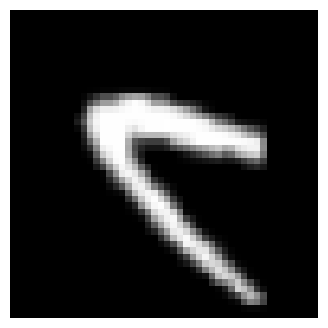

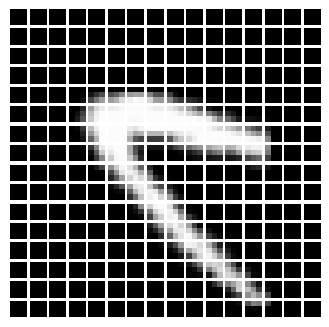

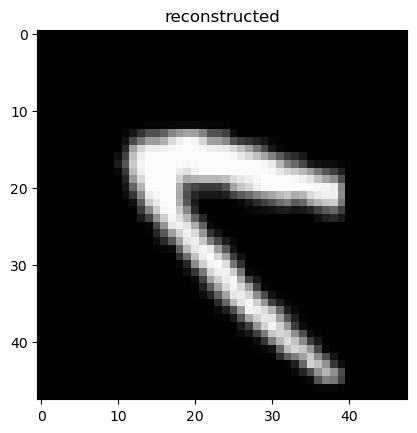

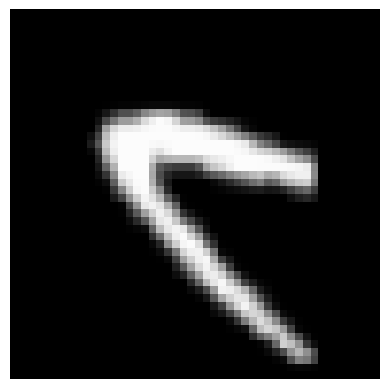

In [8]:
image_batch = next(iter(train_ds))
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)
patch_layer = Patches()
patches = patch_layer(images=augmented_images)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        alreadyMasked=False,
        setMasking=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream
        self.alreadyMasked = alreadyMasked
        self.mask_indicies = 0
        self.unmask_indicies = 0
        self.patches = 0
        self.tmp_x = 0
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )
        if self.downstream:
            return patch_embeddings
        elif self.alreadyMasked:
            if self.setMasking == False:
                mask_indices, unmask_indices = self.get_already_masked_indices(patch_embeddings, patches, batch_size)
            else:
                tmp = self.tmp_x[::2, ::2].flatten()
                mask_indices = np.array([np.where(tmp == 255)[0]])
                unmask_indices = np.array([np.where(tmp != 255)[0]])
                if patch_embeddings.shape[0] != 1:
                    mask_indices = np.tile(mask_indices, (patch_embeddings.shape[0], 1))
                    unmask_indices = np.tile(unmask_indices, (patch_embeddings.shape[0], 1))
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_already_masked_indices(self, patch_embeddings, patches, batch_size):
        plt.title('in get already masked indicies')
        plt.imshow(patches.numpy()[0])
        plt.show()
        unmask_indices, mask_indices = patch_layer.reconstruct_from_patch_and_find_dark_spots_batch(patches.numpy())
        mask_indices = np.array(mask_indices)
        unmask_indices = np.array(unmask_indices)
        return mask_indices, unmask_indices


    def get_random_indices(self, batch_size):
        uni = tf.random.uniform(shape=(batch_size, self.num_patches))
        rand_indices = tf.argsort(uni, axis=-1)
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask:]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]
        new_patch = np.zeros_like(patch)
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx


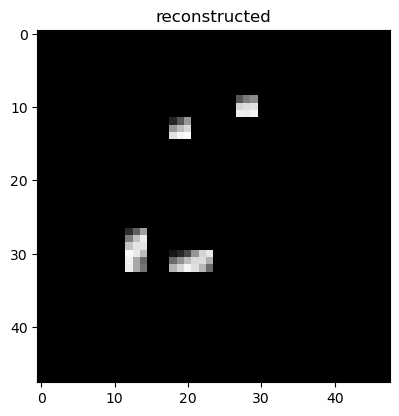

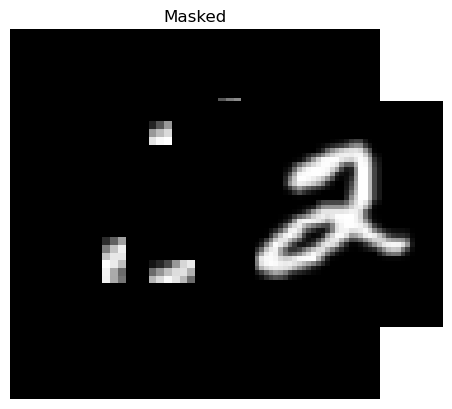

In [10]:
patch_encoder = PatchEncoder()
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [11]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = layers.Add()([x3, x2])
    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="pimae_encoder")

In [13]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = layers.Add()([x3, x2])
    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)
    return keras.Model(inputs, outputs, name="pimae_decoder")

In [14]:
class PIMaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        patches = self.patch_layer(augmented_images)
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)
        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)
        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)
        total_loss = self.compiled_loss(loss_patch, loss_output)
        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [15]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

patch_encoder.alreadyMasked = False

pimae_model = PIMaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [16]:
test_images = next(iter(test_ds))

class PIMAECustomCallback(keras.callbacks.Callback):

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print(' ')
        print("PIMAE Start testing; got log keys: {}".format(keys))
        print(' ')
        test_augmented_images = self.model.test_augmentation_model(test_images)
        test_patches = self.model.patch_layer(test_augmented_images)
        (
            test_unmasked_embeddings,
            test_masked_embeddings,
            test_unmasked_positions,
            test_mask_indices,
            test_unmask_indices,
        ) = self.model.patch_encoder(test_patches)
        test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
        test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
        test_decoder_inputs = tf.concat(
            [test_encoder_outputs, test_masked_embeddings], axis=1
        )
        test_decoder_outputs = self.model.decoder(test_decoder_inputs)
        test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
            test_patches, test_unmask_indices
        )
        print(f"\nIdx chosen: {idx}")
        original_image = test_augmented_images[idx]
        masked_image = self.model.patch_layer.reconstruct_from_patch(
            test_masked_patch
        )
        reconstructed_image = test_decoder_outputs[idx]

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        ax[0].imshow(original_image)
        ax[0].set_title(f"Original:")

        ax[1].imshow(masked_image)
        ax[1].set_title(f"Masked:")

        ax[2].imshow(reconstructed_image)
        ax[2].set_title(f"Resonstructed:")

        plt.show()
        plt.close()

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print(' ')
        print("PIMAE Stop testing; got log keys: {}".format(keys))
        print(' ')

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print(' ')
        print("PIMAE Start predicting; got log keys: {}".format(keys))
        print(' ')

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print(' ')
        print("PIMAE Stop predicting; got log keys: {}".format(keys))
        print(' ')

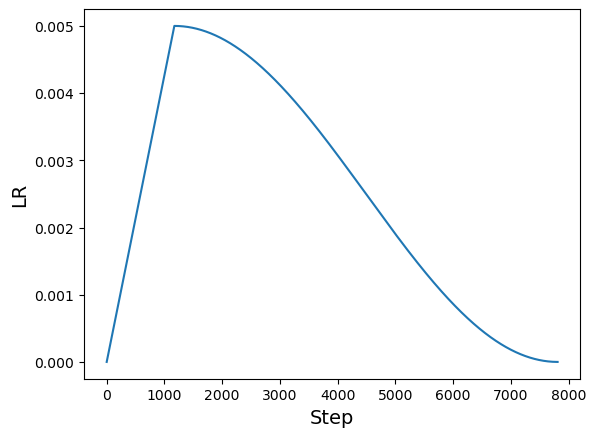

In [17]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 0.0679 - mae: 0.1386 
PIMAE Start testing; got log keys: []
 

Idx chosen: 92


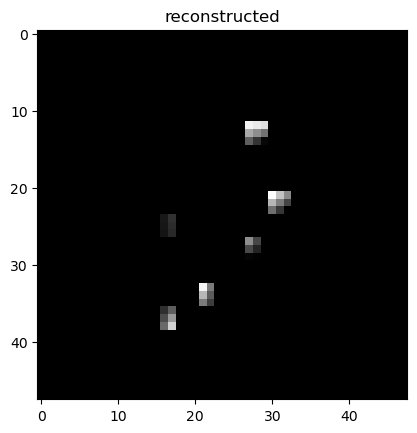

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


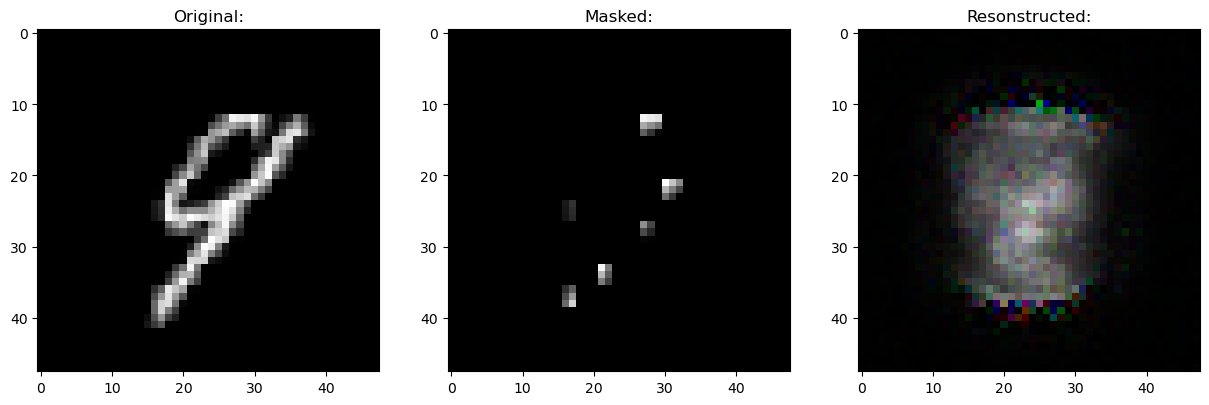

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 562ms/step - loss: 0.0679 - mae: 0.1386 - val_loss: 0.0493 - val_mae: 0.1096
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.0548 - mae: 0.1218

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
PIMAE Start testing; got log keys: []
 

Idx chosen: 14


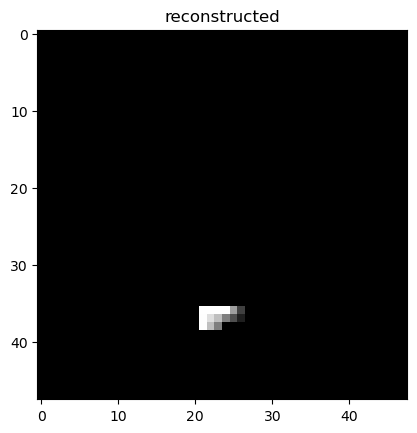

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


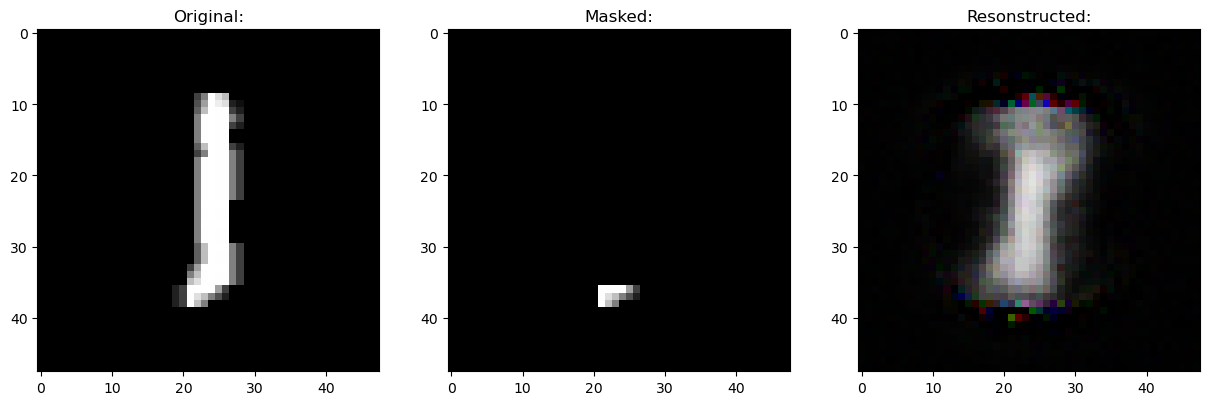

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 562ms/step - loss: 0.0548 - mae: 0.1218 - val_loss: 0.0524 - val_mae: 0.1084
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 0.0518 - mae: 0.1174 
PIMAE Start testing; got log keys: []
 

Idx chosen: 106


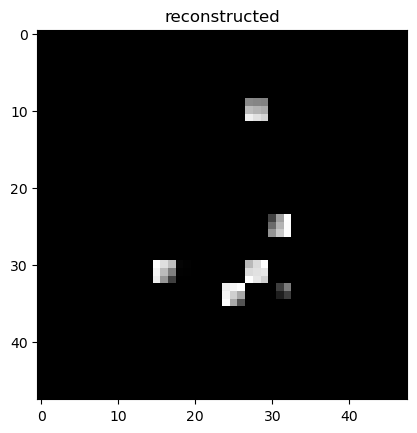

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


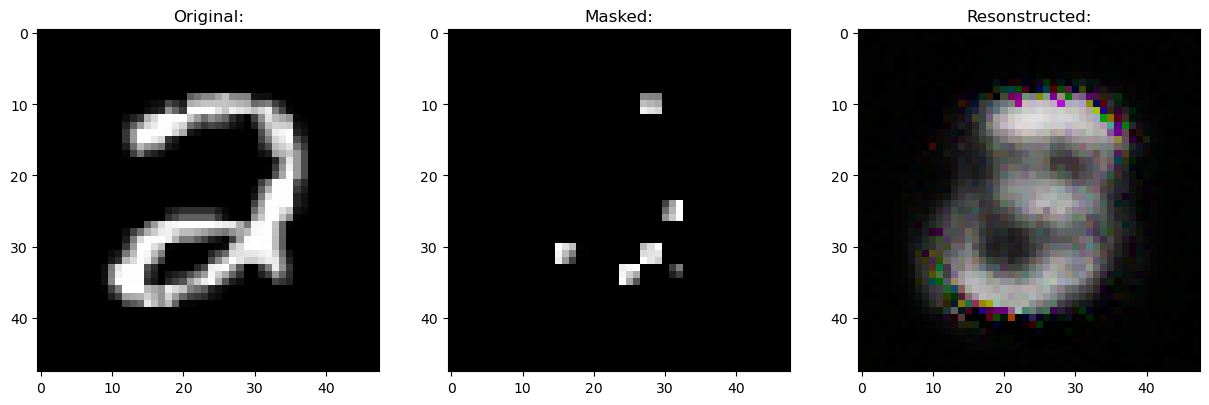

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 562ms/step - loss: 0.0518 - mae: 0.1174 - val_loss: 0.0478 - val_mae: 0.1113
Epoch 4/50
157/157 [==============================] - ETA: 0s - loss: 0.0462 - mae: 0.1152 
PIMAE Start testing; got log keys: []
 

Idx chosen: 71


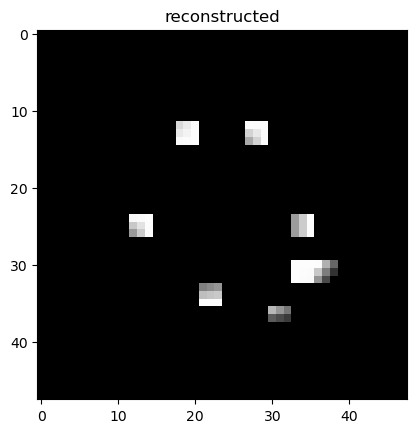

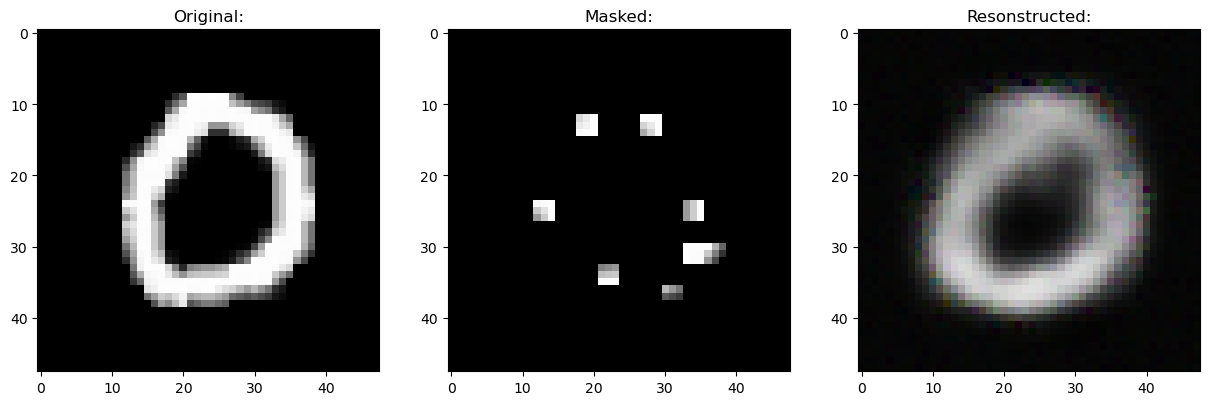

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 566ms/step - loss: 0.0462 - mae: 0.1152 - val_loss: 0.0427 - val_mae: 0.1063
Epoch 5/50
157/157 [==============================] - ETA: 0s - loss: 0.0426 - mae: 0.1107 
PIMAE Start testing; got log keys: []
 

Idx chosen: 188


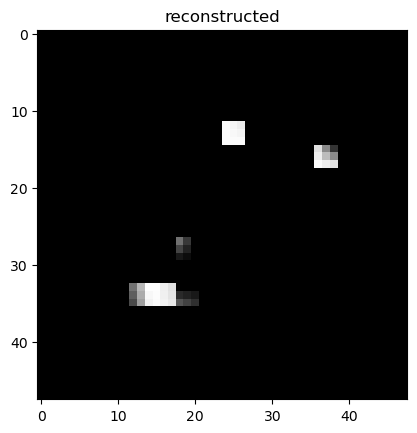

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


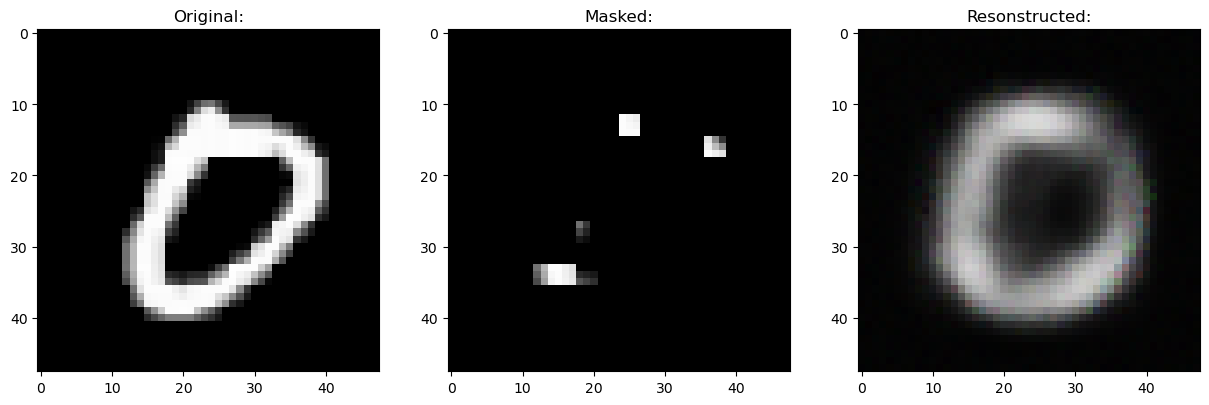

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 559ms/step - loss: 0.0426 - mae: 0.1107 - val_loss: 0.0414 - val_mae: 0.1046
Epoch 6/50
157/157 [==============================] - ETA: 0s - loss: 0.0390 - mae: 0.1034 
PIMAE Start testing; got log keys: []
 

Idx chosen: 20


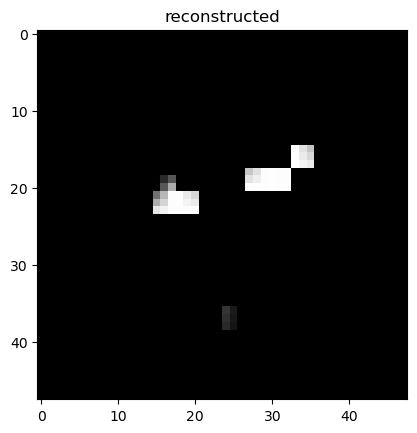

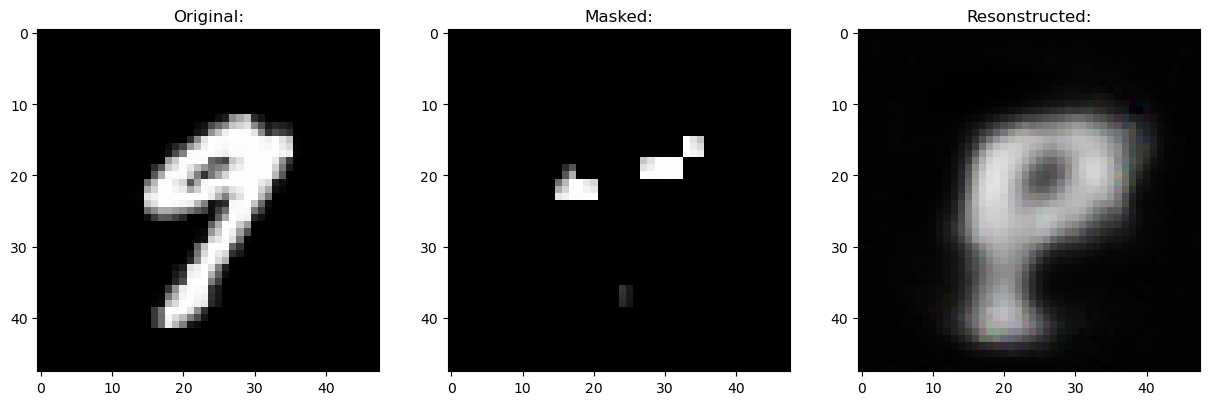

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 571ms/step - loss: 0.0390 - mae: 0.1034 - val_loss: 0.0397 - val_mae: 0.1001
Epoch 7/50
157/157 [==============================] - ETA: 0s - loss: 0.0357 - mae: 0.0962 
PIMAE Start testing; got log keys: []
 

Idx chosen: 102


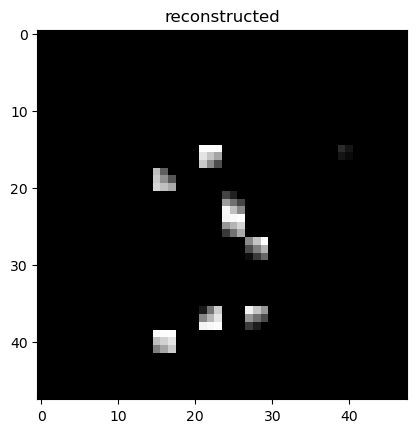

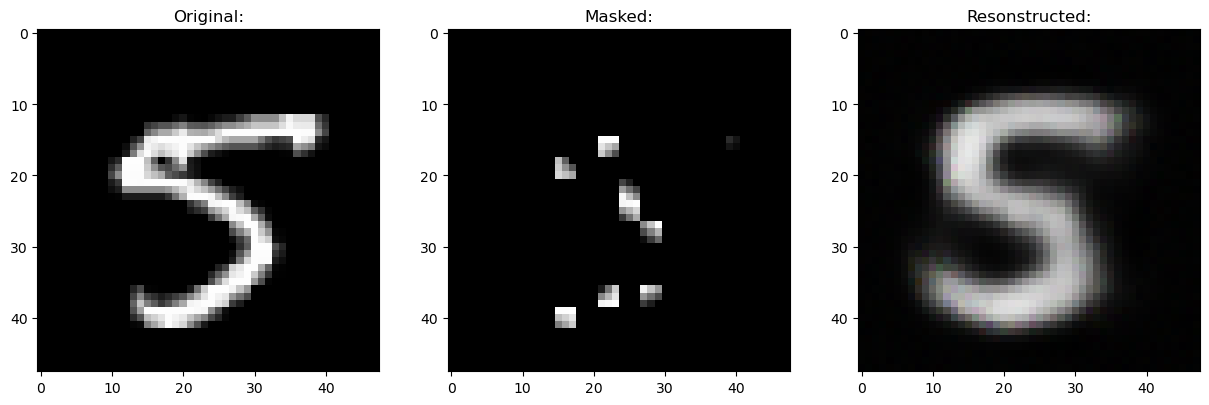

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 95s 607ms/step - loss: 0.0357 - mae: 0.0962 - val_loss: 0.0399 - val_mae: 0.0999
Epoch 8/50
157/157 [==============================] - ETA: 0s - loss: 0.0328 - mae: 0.0899 
PIMAE Start testing; got log keys: []
 

Idx chosen: 121


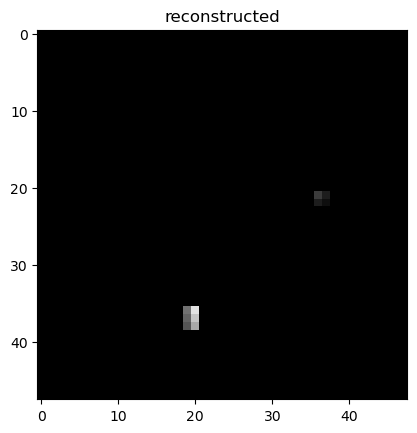

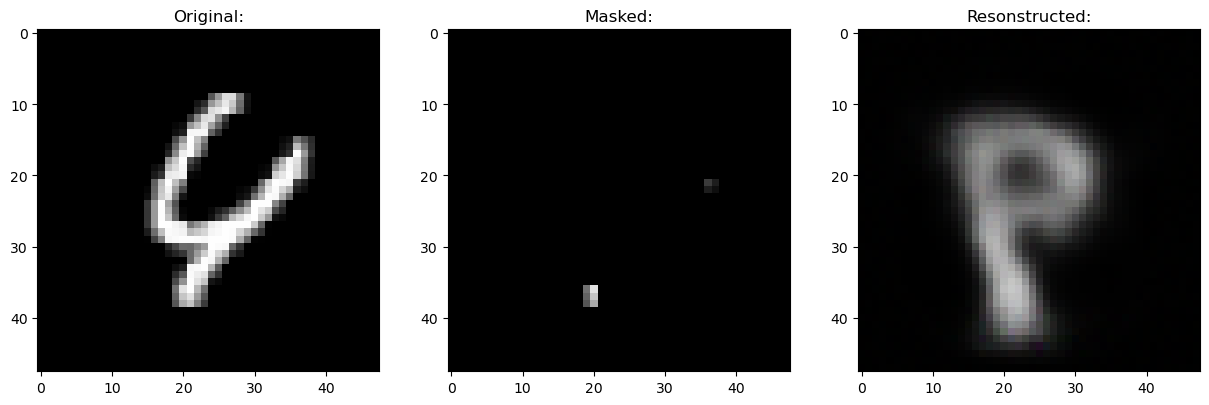

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 564ms/step - loss: 0.0328 - mae: 0.0899 - val_loss: 0.0362 - val_mae: 0.0932
Epoch 9/50
157/157 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.0831 
PIMAE Start testing; got log keys: []
 

Idx chosen: 210


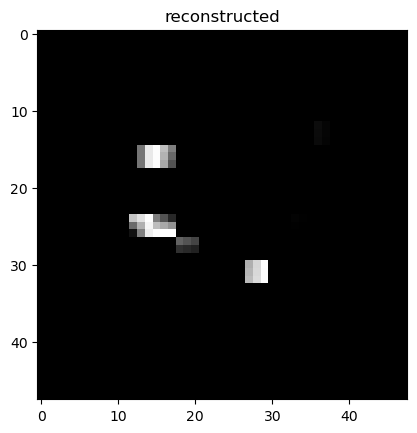

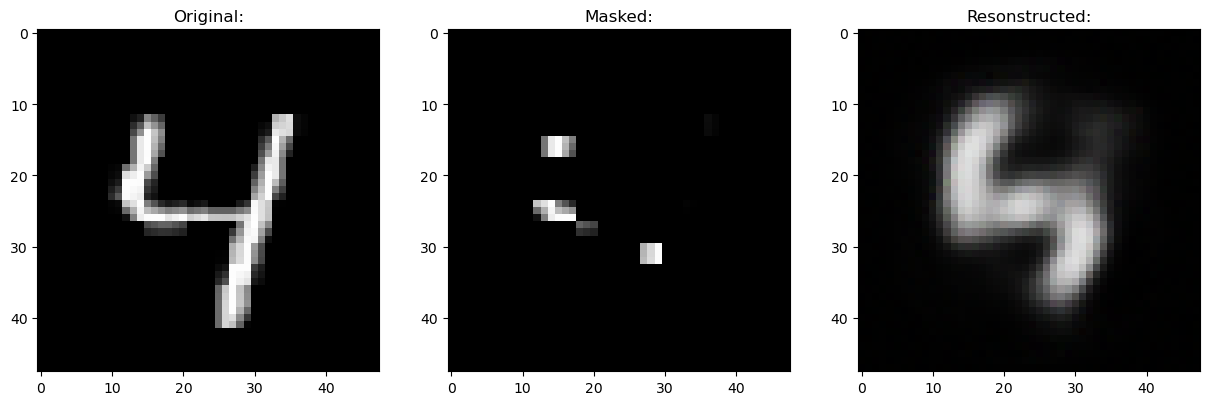

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 562ms/step - loss: 0.0297 - mae: 0.0831 - val_loss: 0.0354 - val_mae: 0.0887
Epoch 10/50
157/157 [==============================] - ETA: 0s - loss: 0.0281 - mae: 0.0798 
PIMAE Start testing; got log keys: []
 

Idx chosen: 214


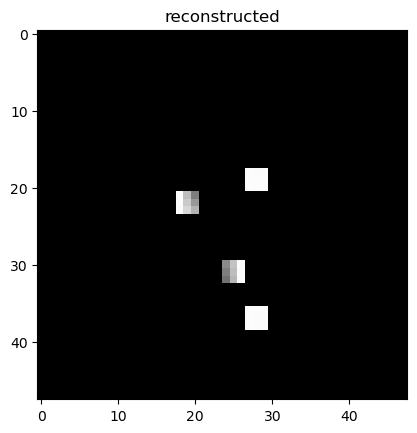

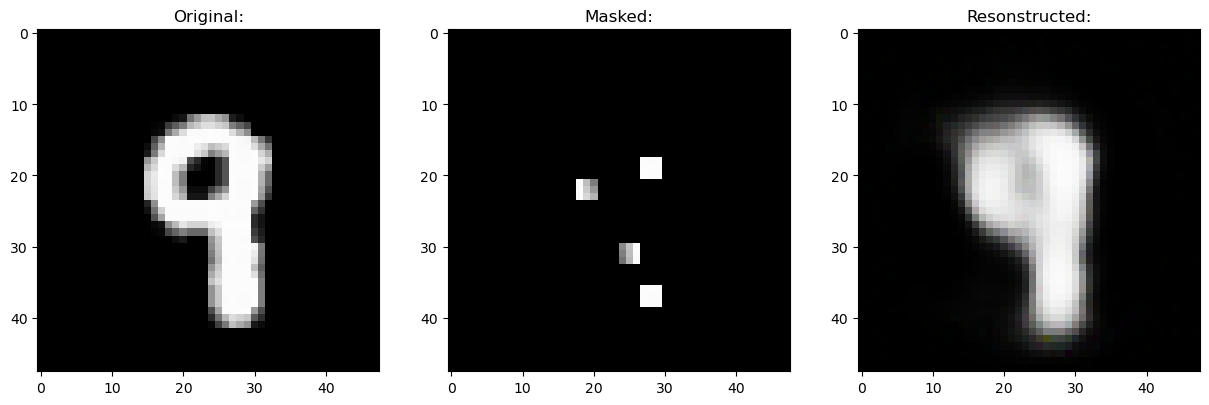

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 567ms/step - loss: 0.0281 - mae: 0.0798 - val_loss: 0.0352 - val_mae: 0.0868
Epoch 11/50
157/157 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.0764

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
PIMAE Start testing; got log keys: []
 

Idx chosen: 74


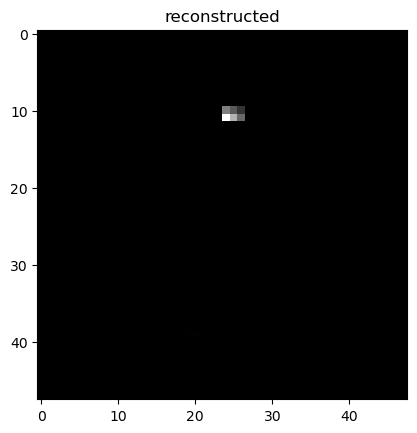

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


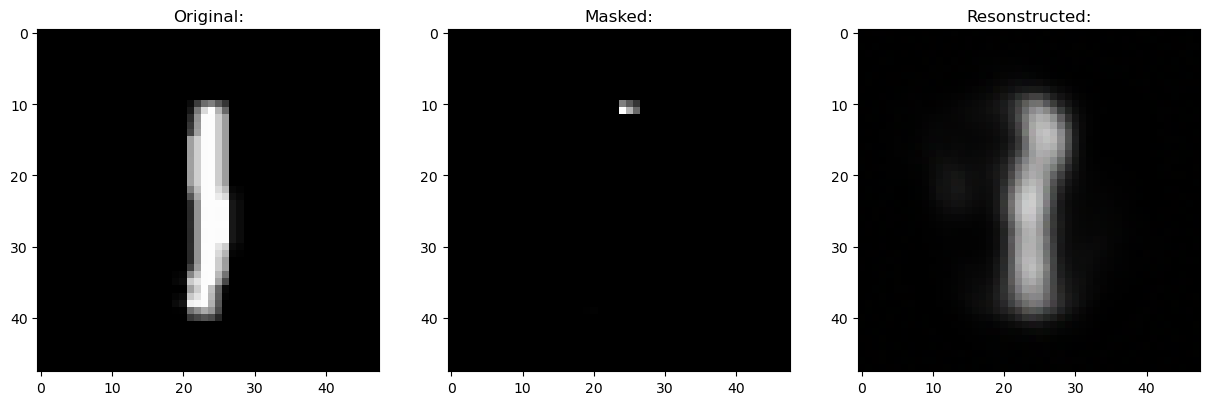

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 574ms/step - loss: 0.0266 - mae: 0.0764 - val_loss: 0.0337 - val_mae: 0.0843
Epoch 12/50
157/157 [==============================] - ETA: 0s - loss: 0.0259 - mae: 0.0747 
PIMAE Start testing; got log keys: []
 

Idx chosen: 202


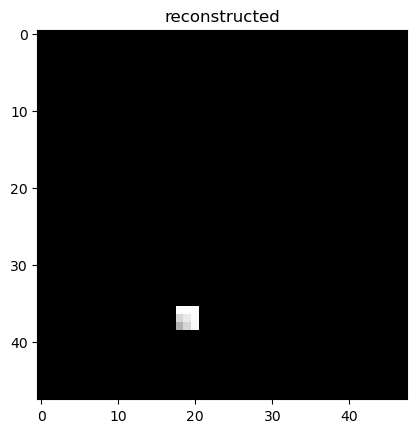

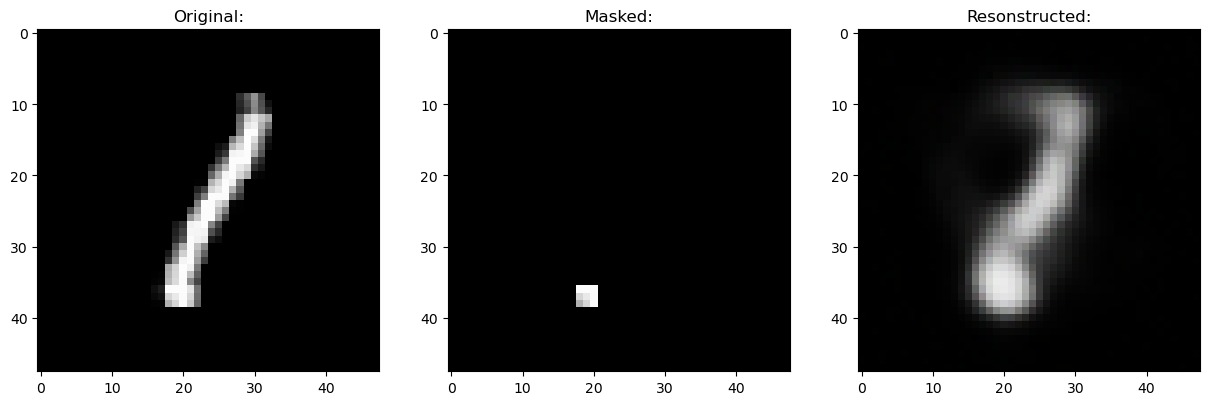

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 95s 602ms/step - loss: 0.0259 - mae: 0.0747 - val_loss: 0.0337 - val_mae: 0.0849
Epoch 13/50
157/157 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.0732 
PIMAE Start testing; got log keys: []
 

Idx chosen: 87


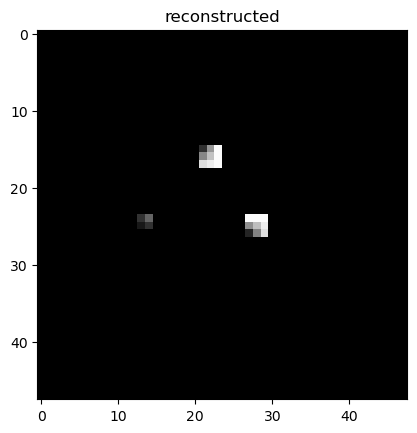

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


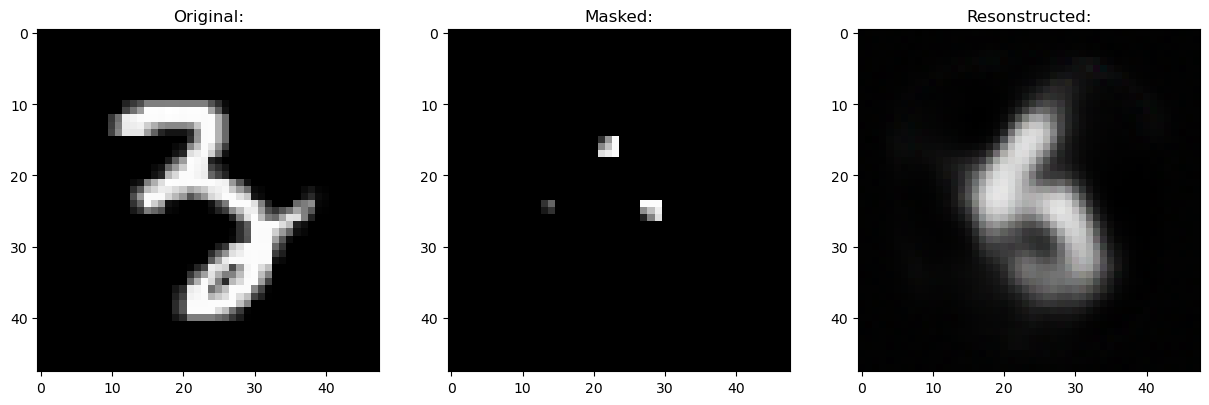

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 94s 600ms/step - loss: 0.0251 - mae: 0.0732 - val_loss: 0.0331 - val_mae: 0.0832
Epoch 14/50
157/157 [==============================] - ETA: 0s - loss: 0.0245 - mae: 0.0719 
PIMAE Start testing; got log keys: []
 

Idx chosen: 116


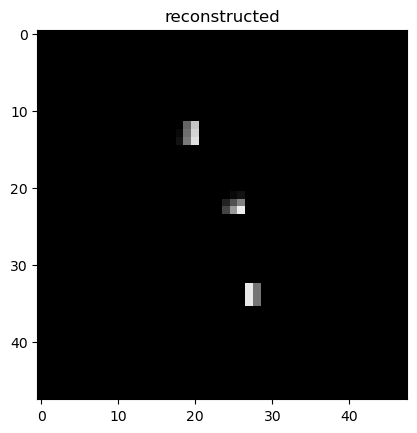

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


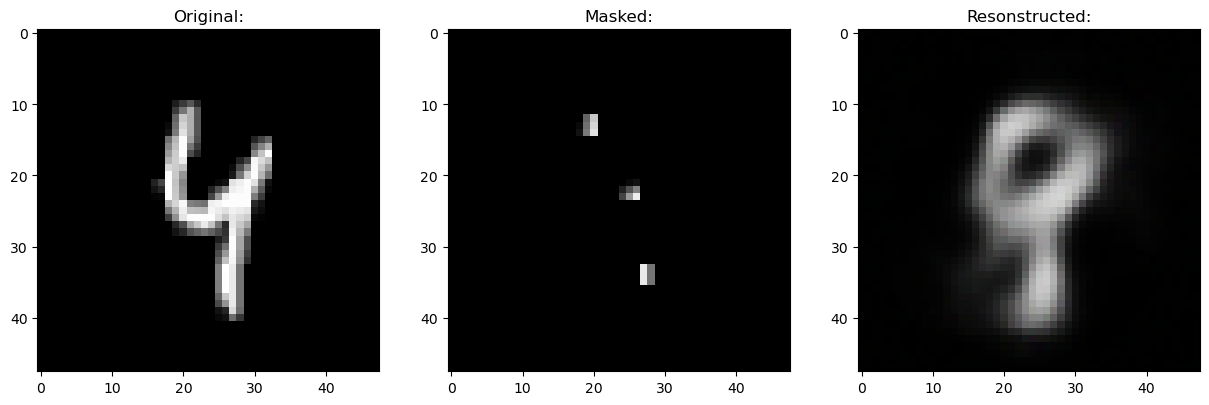

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 571ms/step - loss: 0.0245 - mae: 0.0719 - val_loss: 0.0328 - val_mae: 0.0848
Epoch 15/50
157/157 [==============================] - ETA: 0s - loss: 0.0238 - mae: 0.0704 
PIMAE Start testing; got log keys: []
 

Idx chosen: 99


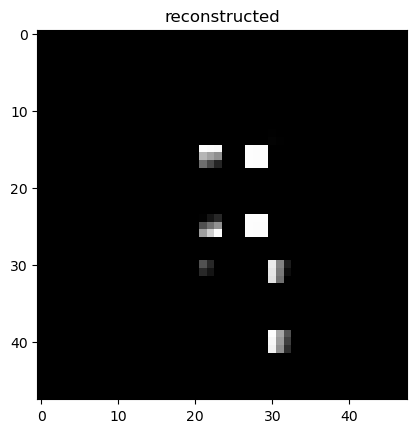

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


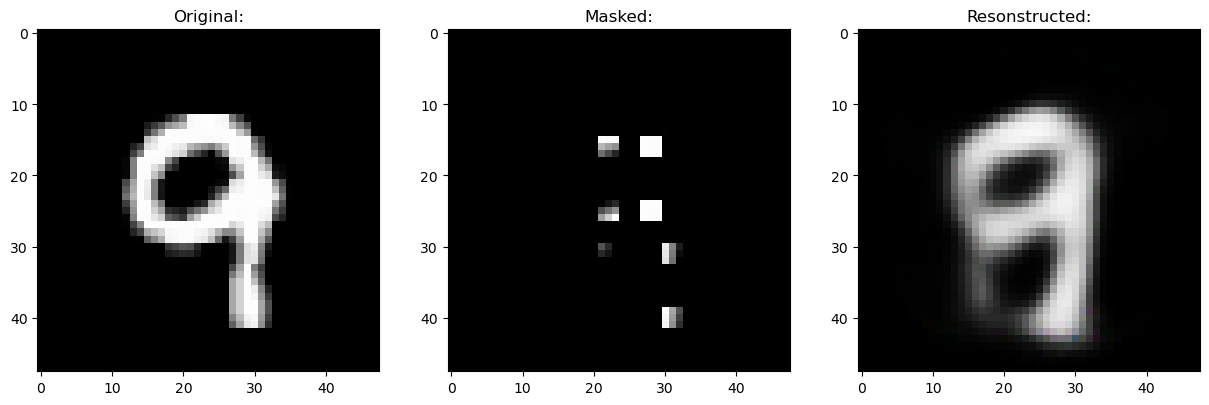

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 562ms/step - loss: 0.0238 - mae: 0.0704 - val_loss: 0.0320 - val_mae: 0.0823
Epoch 16/50
157/157 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.0691 
PIMAE Start testing; got log keys: []
 

Idx chosen: 103


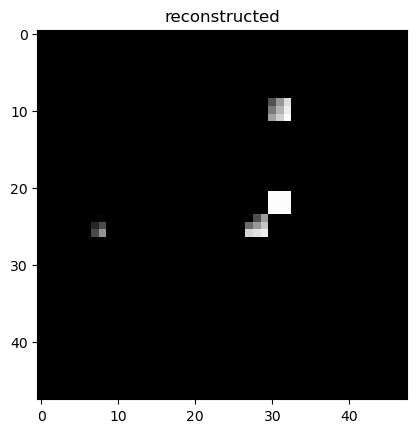

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


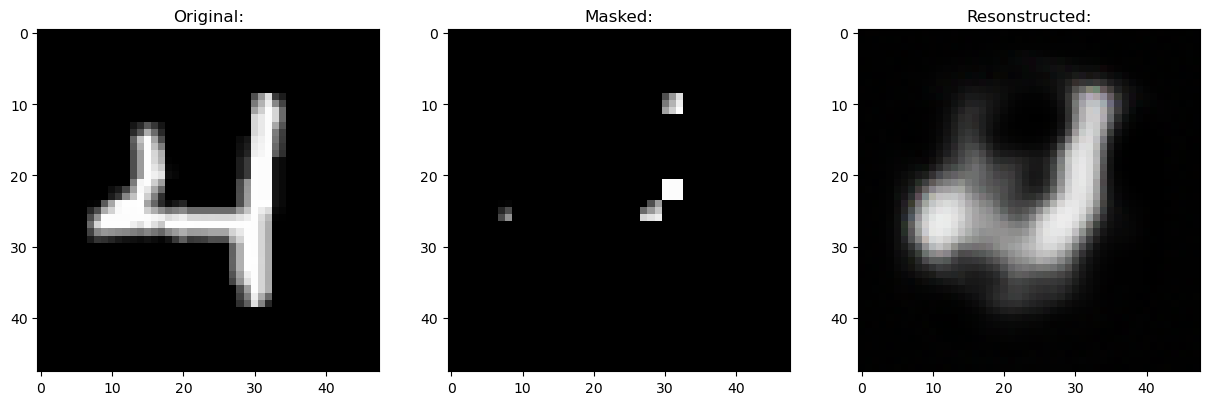

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 574ms/step - loss: 0.0233 - mae: 0.0691 - val_loss: 0.0315 - val_mae: 0.0812
Epoch 17/50
157/157 [==============================] - ETA: 0s - loss: 0.0229 - mae: 0.0682 
PIMAE Start testing; got log keys: []
 

Idx chosen: 151


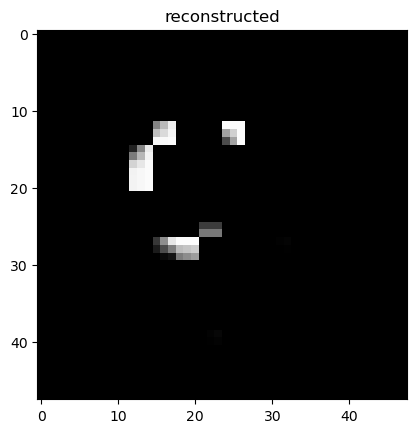

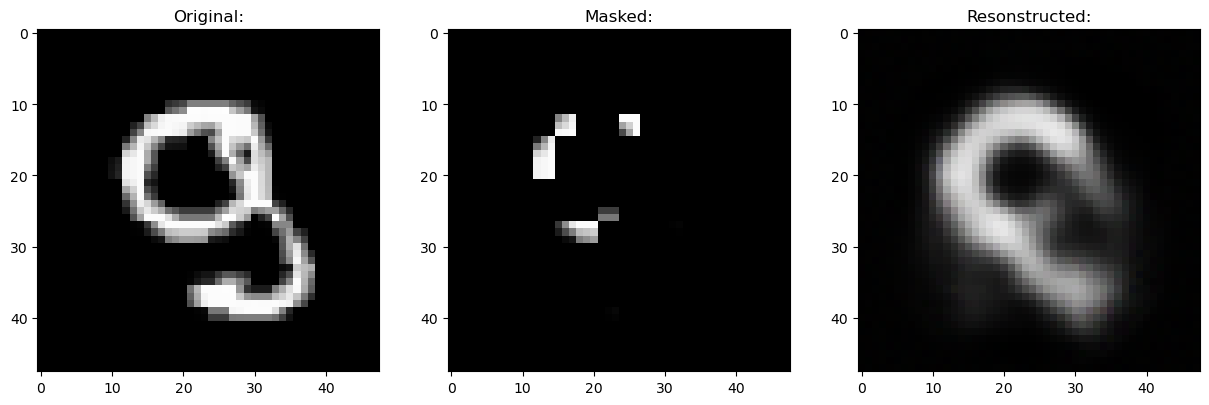

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 92s 584ms/step - loss: 0.0229 - mae: 0.0682 - val_loss: 0.0317 - val_mae: 0.0823
Epoch 18/50
157/157 [==============================] - ETA: 0s - loss: 0.0228 - mae: 0.0682

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
PIMAE Start testing; got log keys: []
 

Idx chosen: 130


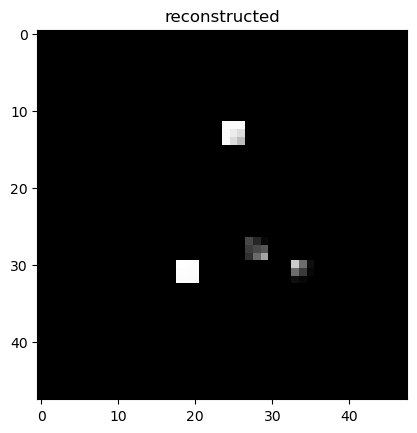

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


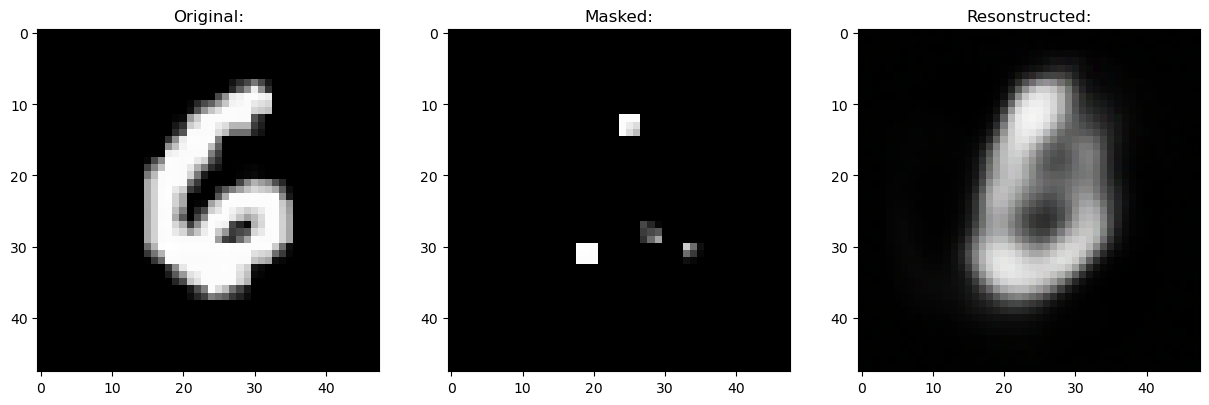

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 564ms/step - loss: 0.0228 - mae: 0.0682 - val_loss: 0.0323 - val_mae: 0.0817
Epoch 19/50
157/157 [==============================] - ETA: 0s - loss: 0.0222 - mae: 0.0669 
PIMAE Start testing; got log keys: []
 

Idx chosen: 149


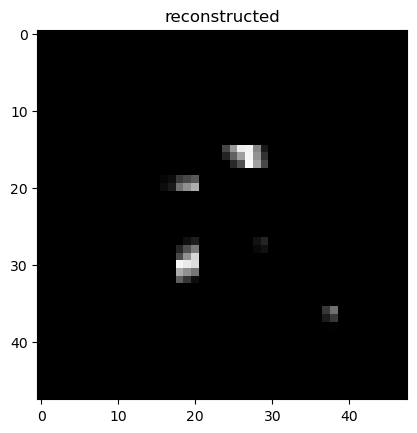

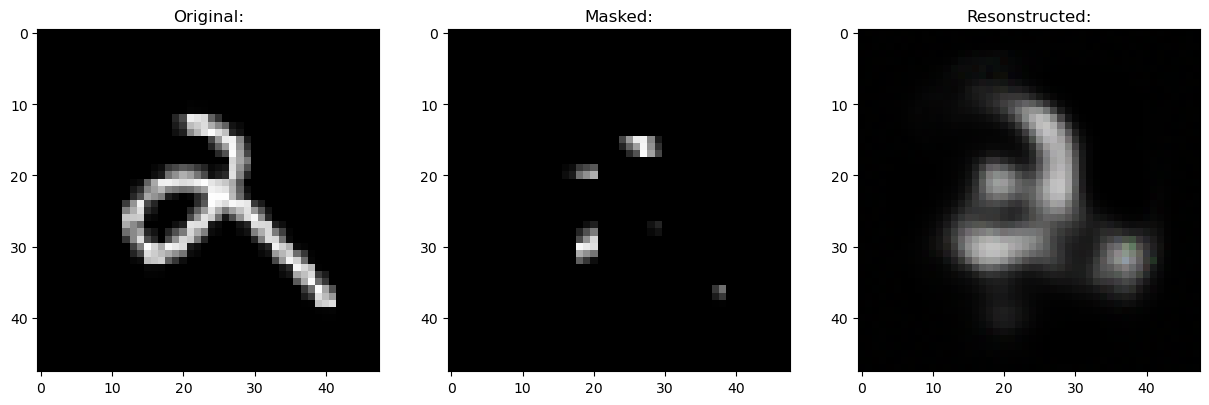

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 95s 606ms/step - loss: 0.0222 - mae: 0.0669 - val_loss: 0.0309 - val_mae: 0.0800
Epoch 20/50
157/157 [==============================] - ETA: 0s - loss: 0.0220 - mae: 0.0662 
PIMAE Start testing; got log keys: []
 

Idx chosen: 52


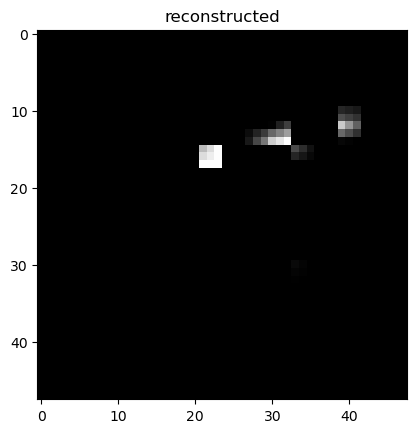

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


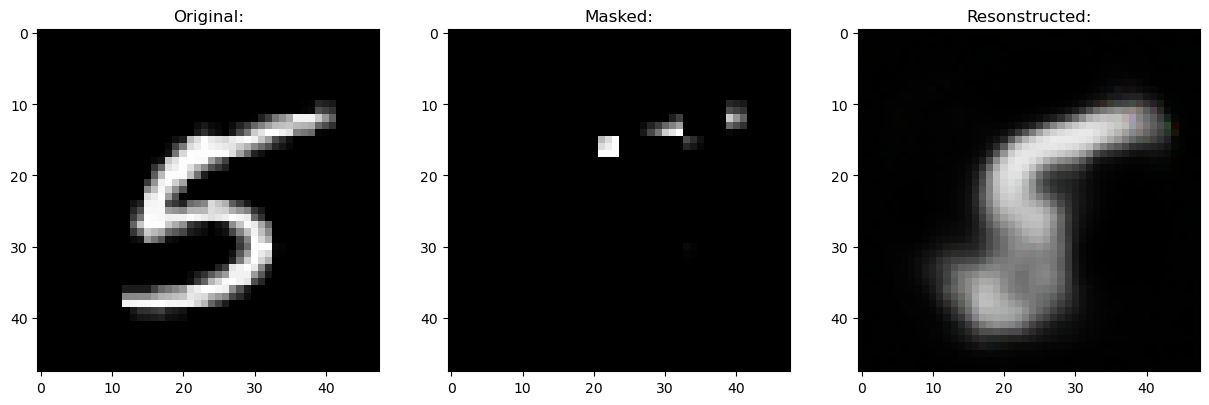

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 101s 647ms/step - loss: 0.0220 - mae: 0.0662 - val_loss: 0.0319 - val_mae: 0.0802
Epoch 21/50
157/157 [==============================] - ETA: 0s - loss: 0.0217 - mae: 0.0655 
PIMAE Start testing; got log keys: []
 

Idx chosen: 1


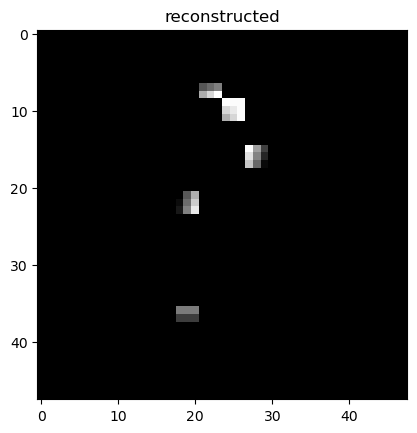

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


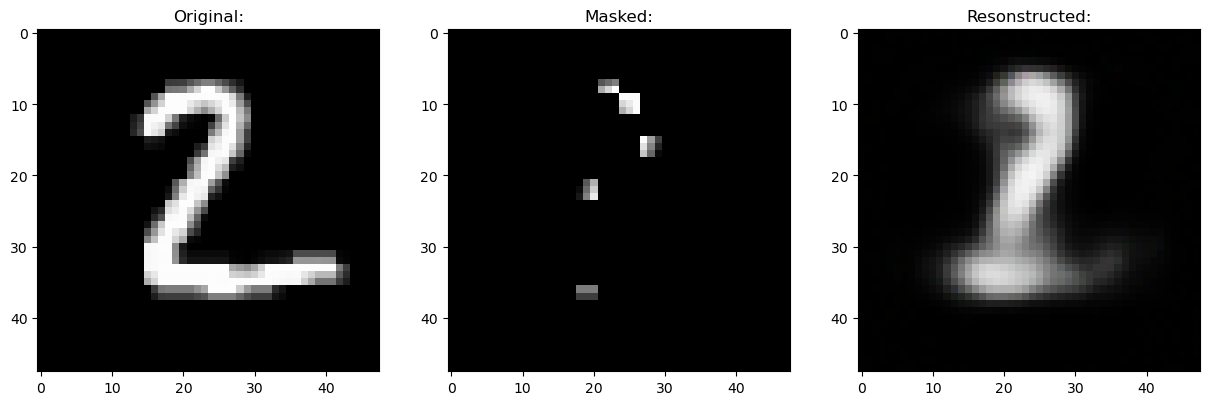

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 568ms/step - loss: 0.0217 - mae: 0.0655 - val_loss: 0.0327 - val_mae: 0.0819
Epoch 22/50
157/157 [==============================] - ETA: 0s - loss: 0.0213 - mae: 0.0646 
PIMAE Start testing; got log keys: []
 

Idx chosen: 87


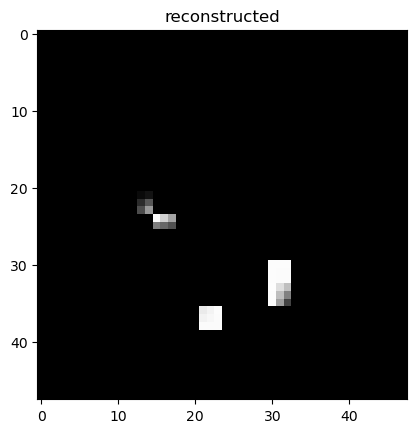

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


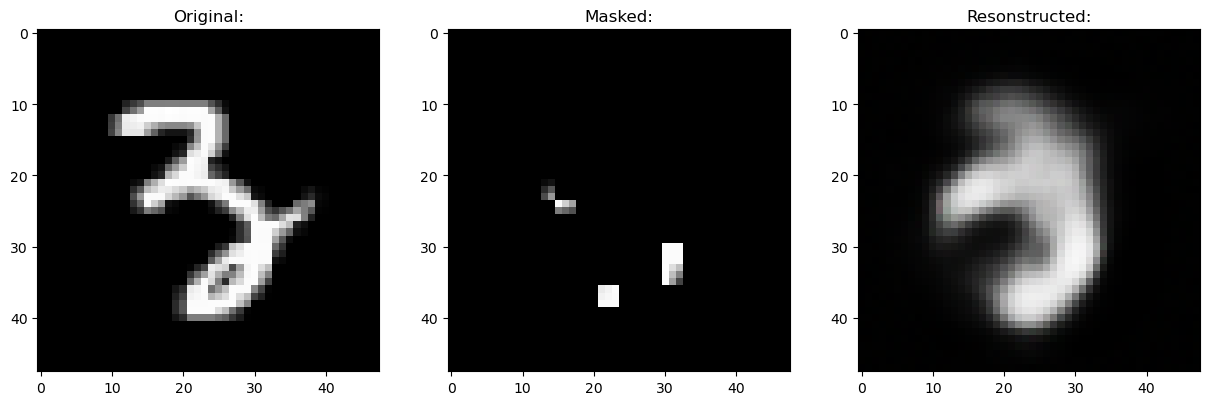

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 563ms/step - loss: 0.0213 - mae: 0.0646 - val_loss: 0.0315 - val_mae: 0.0798
Epoch 23/50
157/157 [==============================] - ETA: 0s - loss: 0.0212 - mae: 0.0645 
PIMAE Start testing; got log keys: []
 

Idx chosen: 235


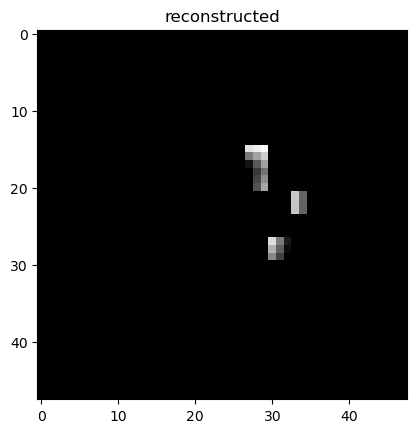

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


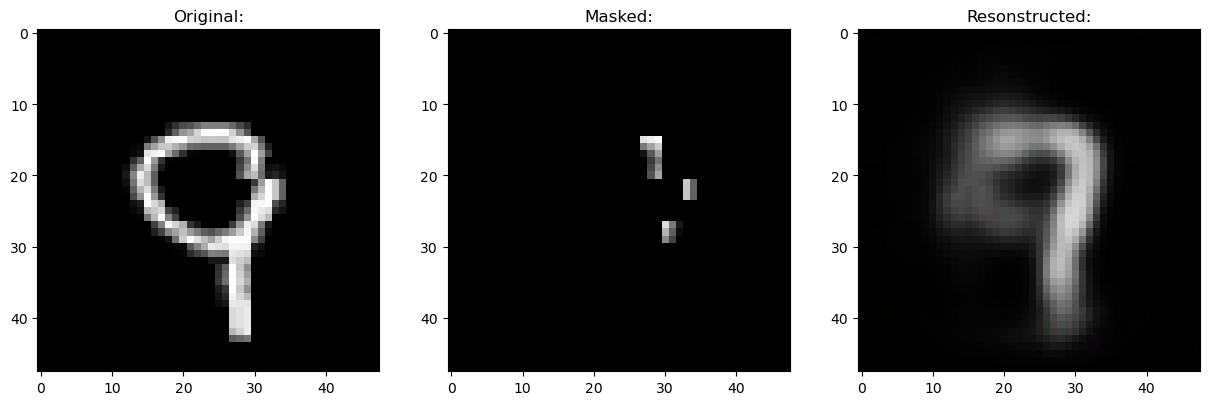

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 566ms/step - loss: 0.0212 - mae: 0.0645 - val_loss: 0.0309 - val_mae: 0.0803
Epoch 24/50
157/157 [==============================] - ETA: 0s - loss: 0.0211 - mae: 0.0642 
PIMAE Start testing; got log keys: []
 

Idx chosen: 157


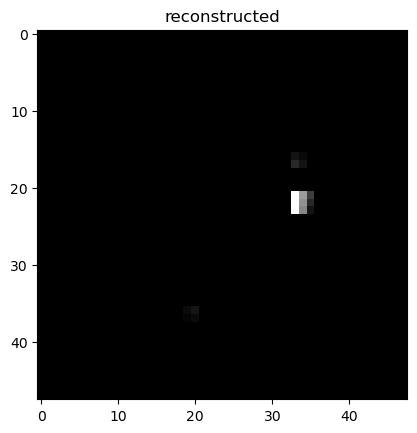

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


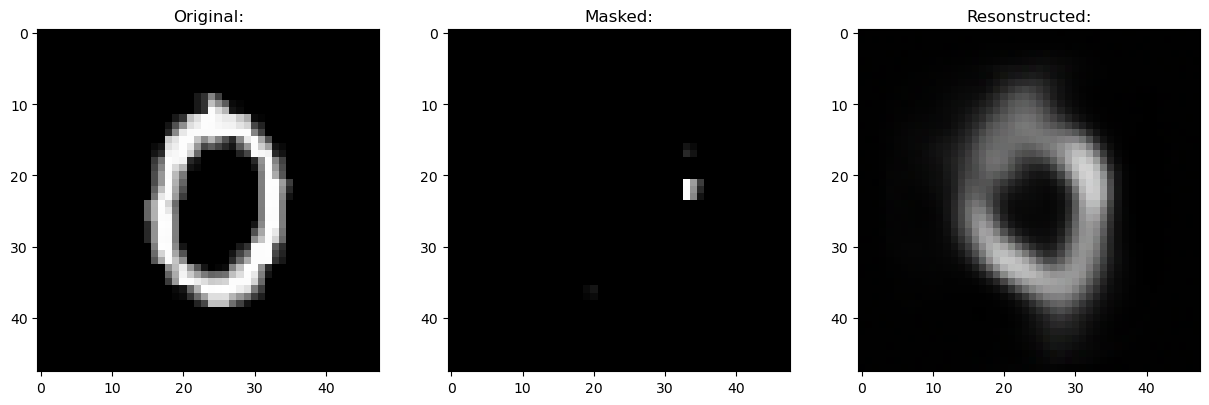

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 95s 609ms/step - loss: 0.0211 - mae: 0.0642 - val_loss: 0.0321 - val_mae: 0.0816
Epoch 25/50
157/157 [==============================] - ETA: 0s - loss: 0.0208 - mae: 0.0637 
PIMAE Start testing; got log keys: []
 

Idx chosen: 37


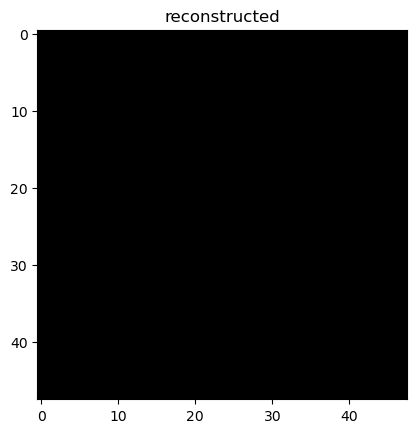

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


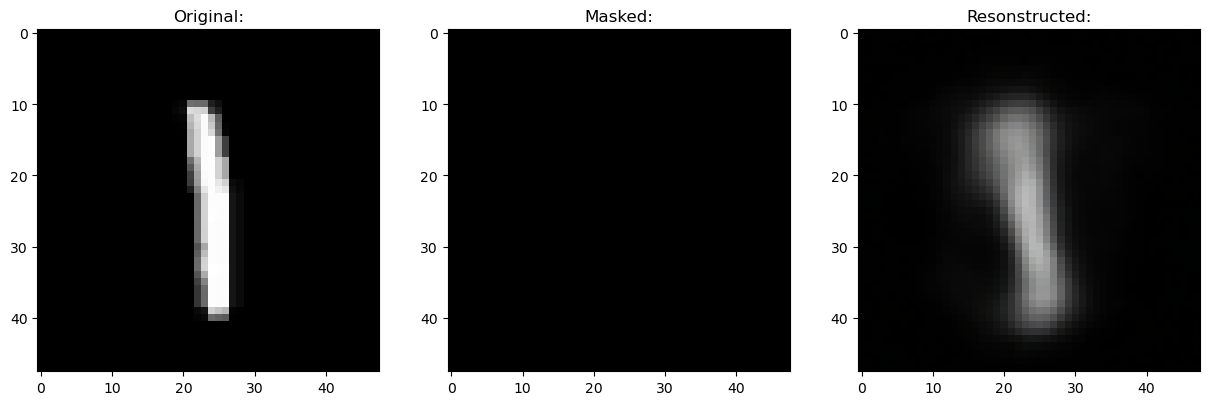

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 95s 606ms/step - loss: 0.0208 - mae: 0.0637 - val_loss: 0.0321 - val_mae: 0.0825
Epoch 26/50
157/157 [==============================] - ETA: 0s - loss: 0.0207 - mae: 0.0635 
PIMAE Start testing; got log keys: []
 

Idx chosen: 129


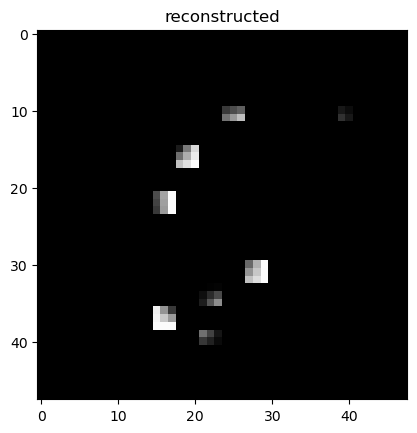

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


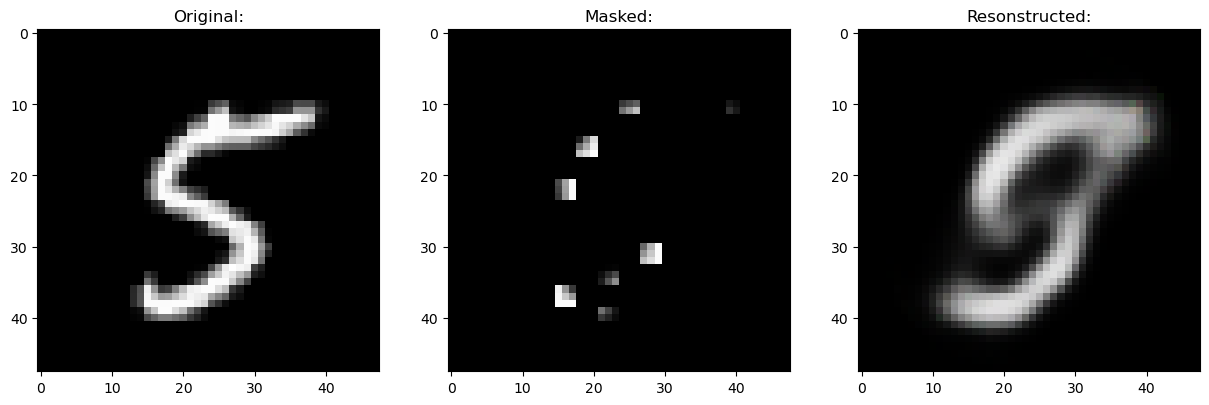

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 95s 603ms/step - loss: 0.0207 - mae: 0.0635 - val_loss: 0.0316 - val_mae: 0.0803
Epoch 27/50
157/157 [==============================] - ETA: 0s - loss: 0.0204 - mae: 0.0625 
PIMAE Start testing; got log keys: []
 

Idx chosen: 191


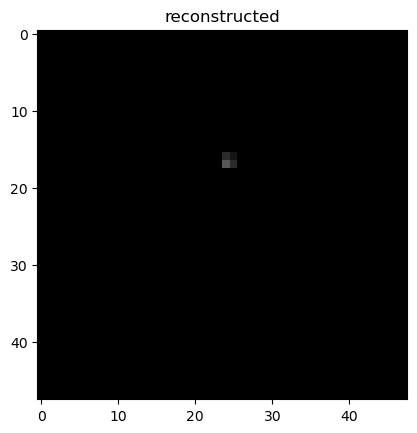

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


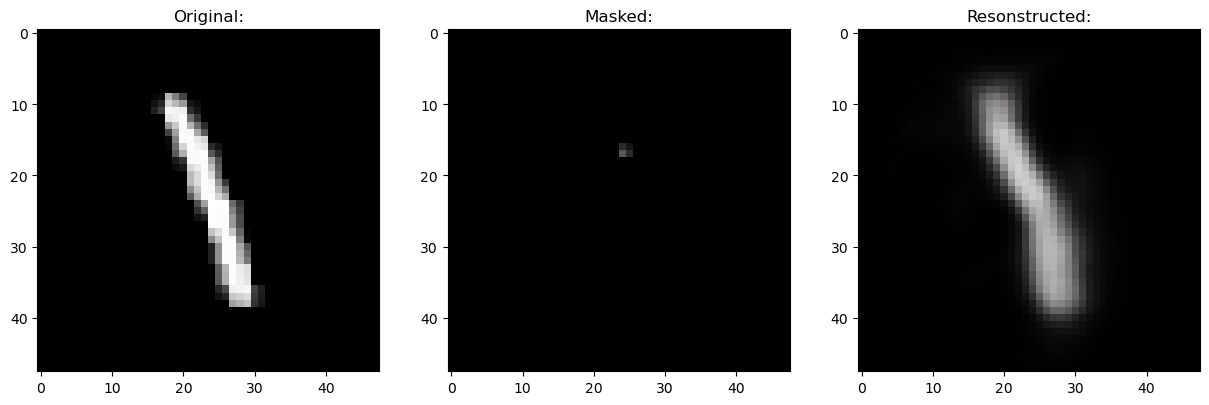

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 96s 609ms/step - loss: 0.0204 - mae: 0.0625 - val_loss: 0.0302 - val_mae: 0.0793
Epoch 28/50
157/157 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.0614 
PIMAE Start testing; got log keys: []
 

Idx chosen: 187


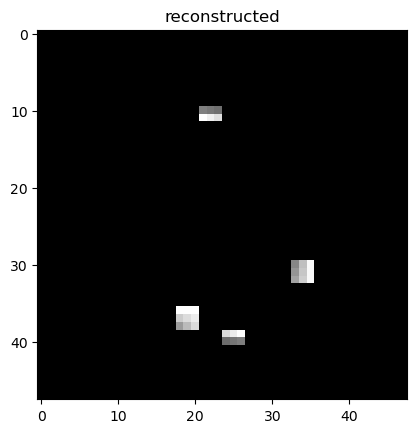

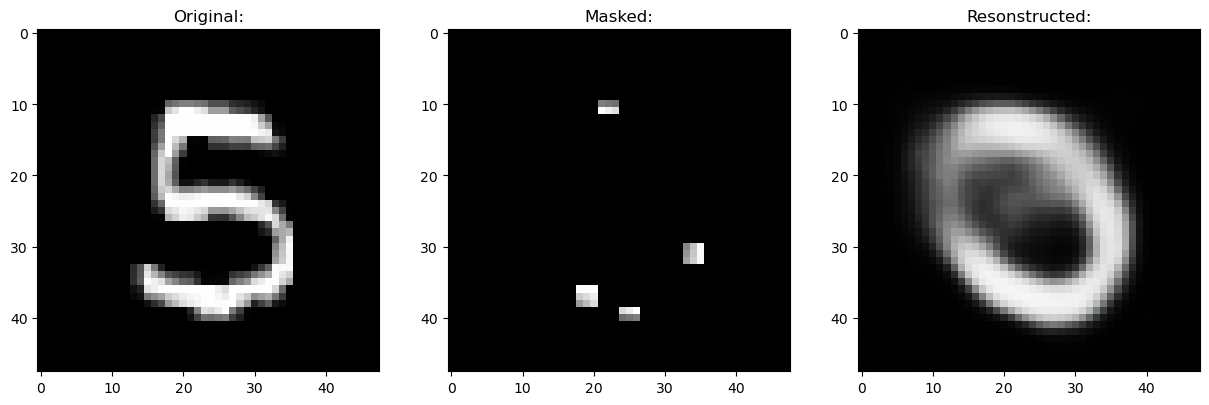

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 95s 608ms/step - loss: 0.0199 - mae: 0.0614 - val_loss: 0.0315 - val_mae: 0.0792
Epoch 29/50
157/157 [==============================] - ETA: 0s - loss: 0.0198 - mae: 0.0611 
PIMAE Start testing; got log keys: []
 

Idx chosen: 20


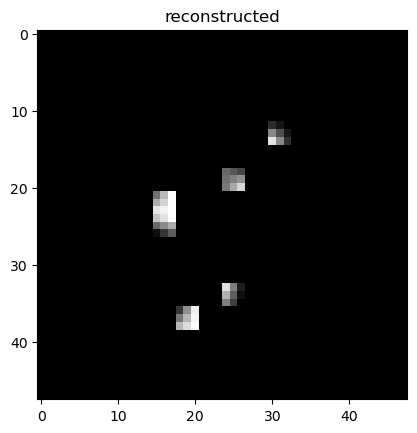

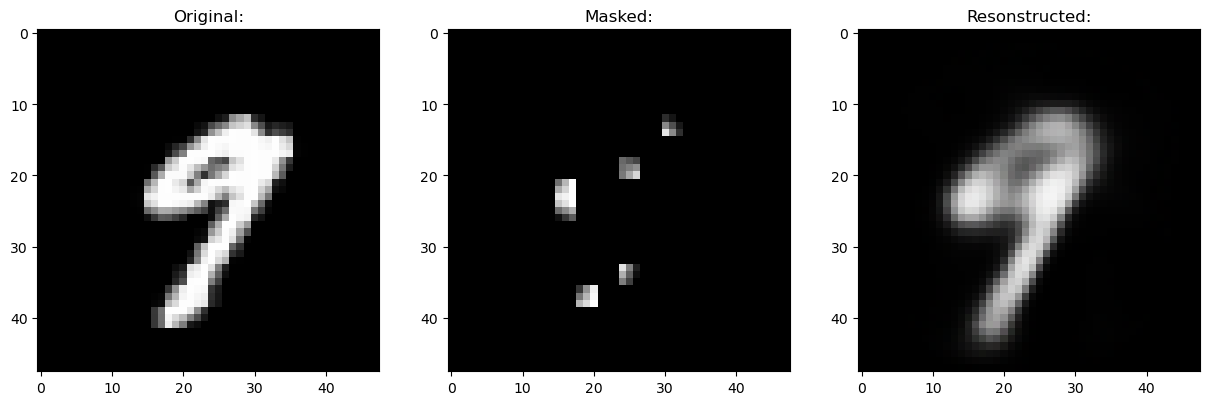

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 567ms/step - loss: 0.0198 - mae: 0.0611 - val_loss: 0.0292 - val_mae: 0.0766
Epoch 30/50
157/157 [==============================] - ETA: 0s - loss: 0.0197 - mae: 0.0610 
PIMAE Start testing; got log keys: []
 

Idx chosen: 160


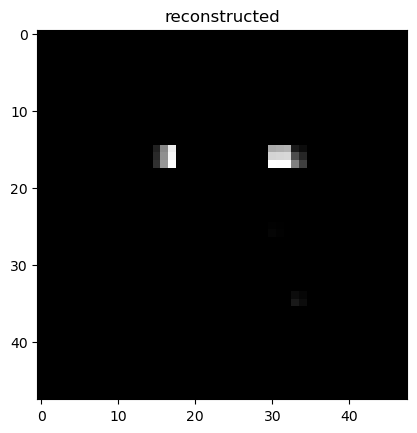

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


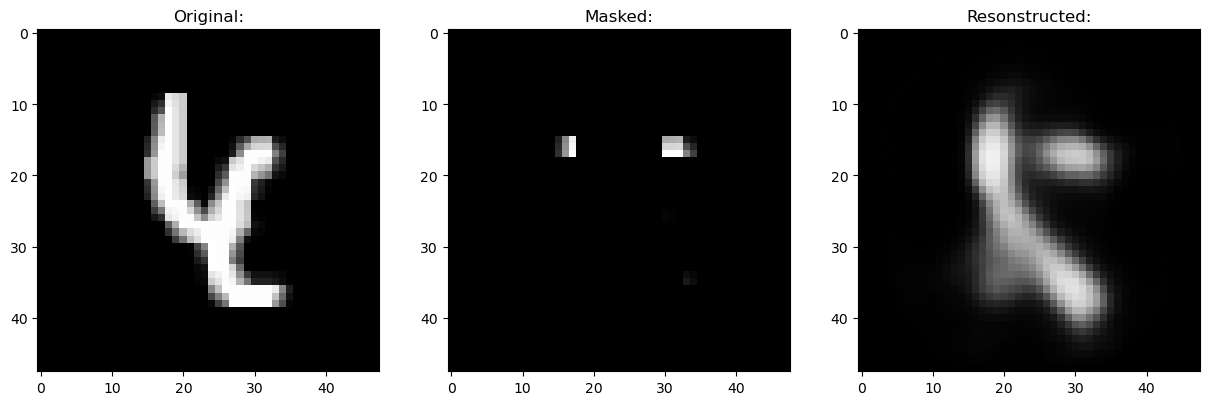

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 561ms/step - loss: 0.0197 - mae: 0.0610 - val_loss: 0.0315 - val_mae: 0.0786
Epoch 31/50
157/157 [==============================] - ETA: 0s - loss: 0.0194 - mae: 0.0602 
PIMAE Start testing; got log keys: []
 

Idx chosen: 203


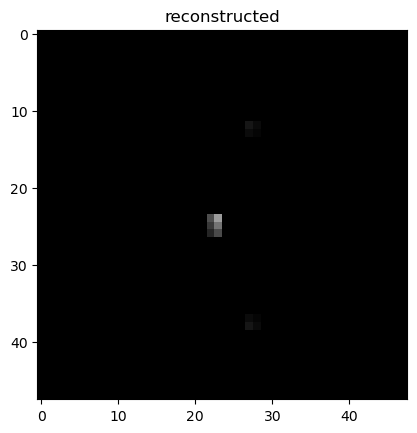

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


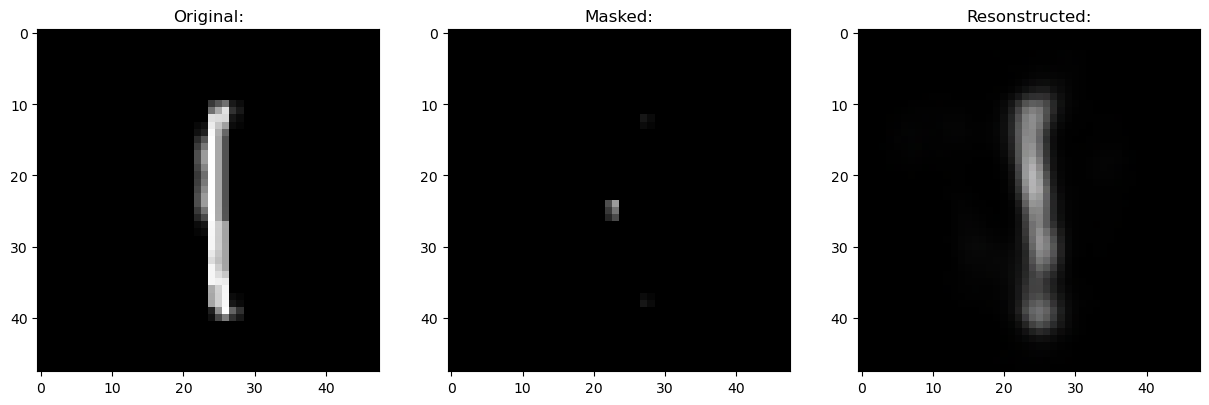

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 564ms/step - loss: 0.0194 - mae: 0.0602 - val_loss: 0.0312 - val_mae: 0.0780
Epoch 32/50
157/157 [==============================] - ETA: 0s - loss: 0.0190 - mae: 0.0591 
PIMAE Start testing; got log keys: []
 

Idx chosen: 57


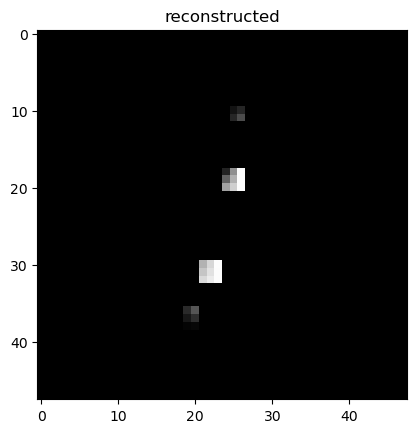

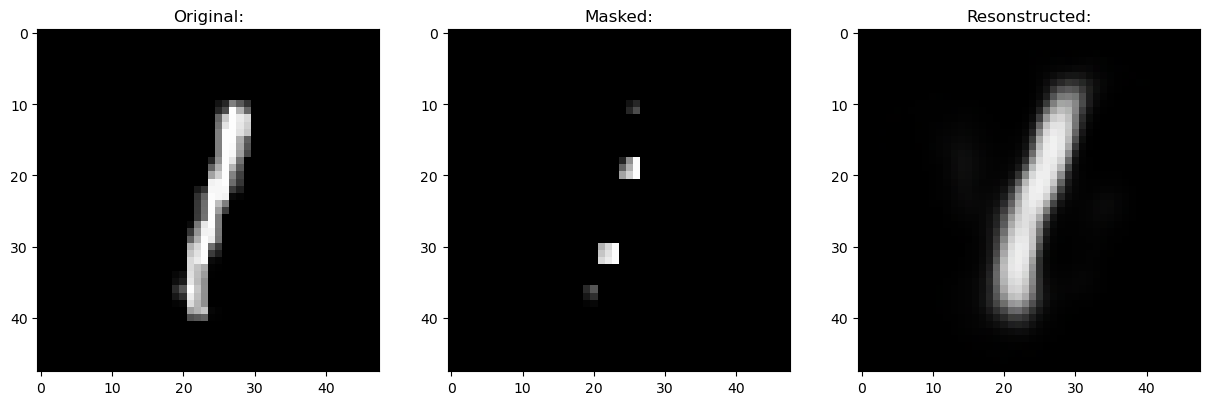

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 567ms/step - loss: 0.0190 - mae: 0.0591 - val_loss: 0.0300 - val_mae: 0.0768
Epoch 33/50
157/157 [==============================] - ETA: 0s - loss: 0.0190 - mae: 0.0591 
PIMAE Start testing; got log keys: []
 

Idx chosen: 21


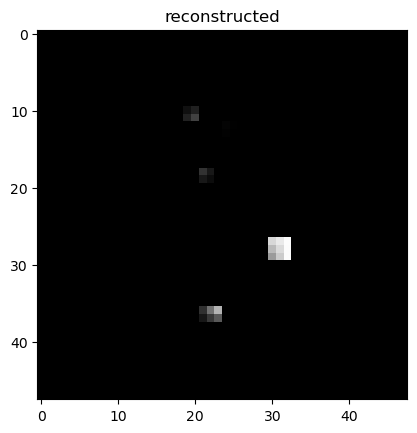

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


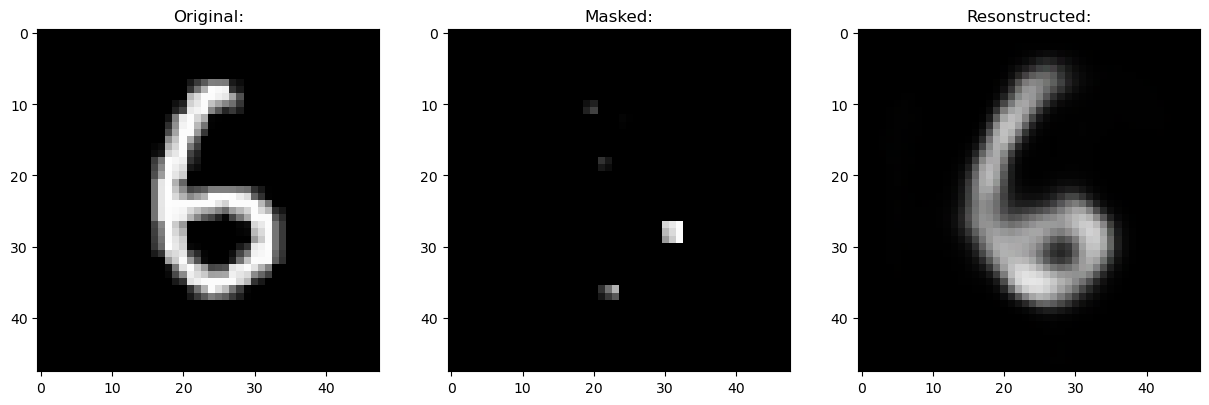

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 91s 577ms/step - loss: 0.0190 - mae: 0.0591 - val_loss: 0.0300 - val_mae: 0.0762
Epoch 34/50
157/157 [==============================] - ETA: 0s - loss: 0.0188 - mae: 0.0586 
PIMAE Start testing; got log keys: []
 

Idx chosen: 252


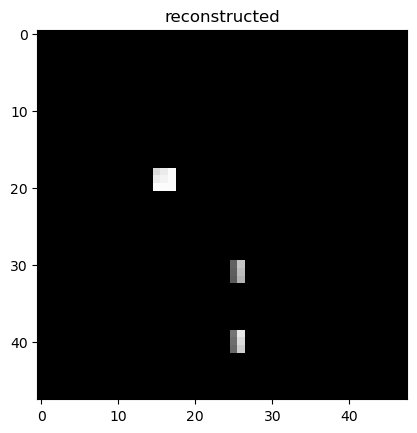

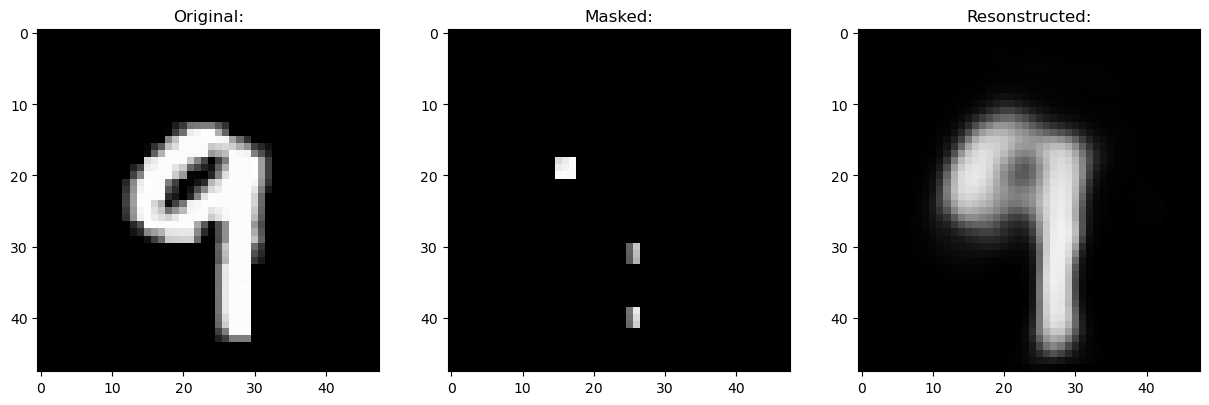

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 574ms/step - loss: 0.0188 - mae: 0.0586 - val_loss: 0.0311 - val_mae: 0.0790
Epoch 35/50
157/157 [==============================] - ETA: 0s - loss: 0.0186 - mae: 0.0583 
PIMAE Start testing; got log keys: []
 

Idx chosen: 235


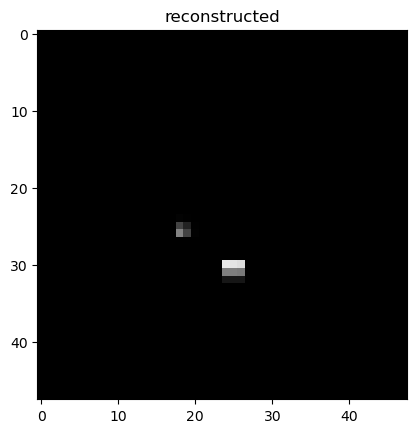

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


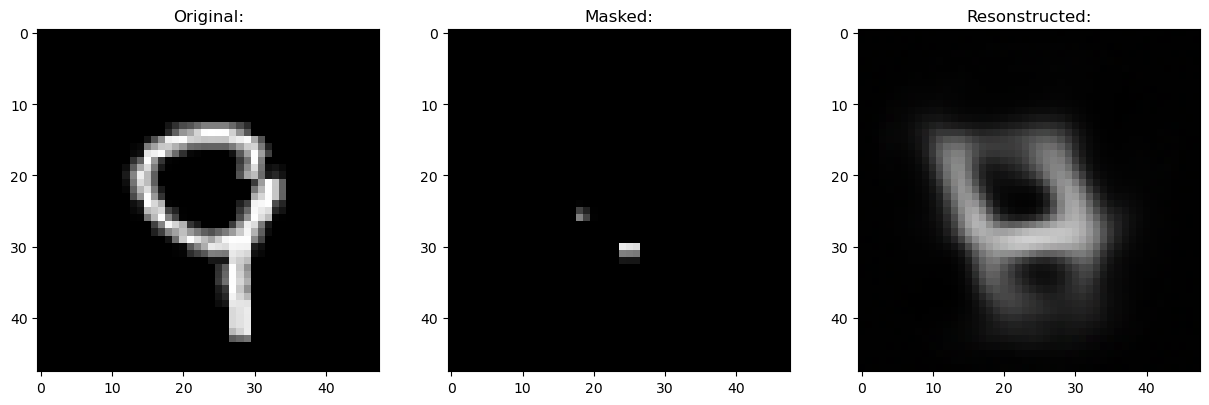

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 91s 577ms/step - loss: 0.0186 - mae: 0.0583 - val_loss: 0.0297 - val_mae: 0.0776
Epoch 36/50
157/157 [==============================] - ETA: 0s - loss: 0.0183 - mae: 0.0575 
PIMAE Start testing; got log keys: []
 

Idx chosen: 88


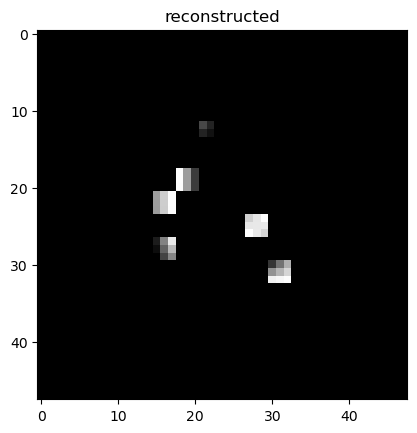

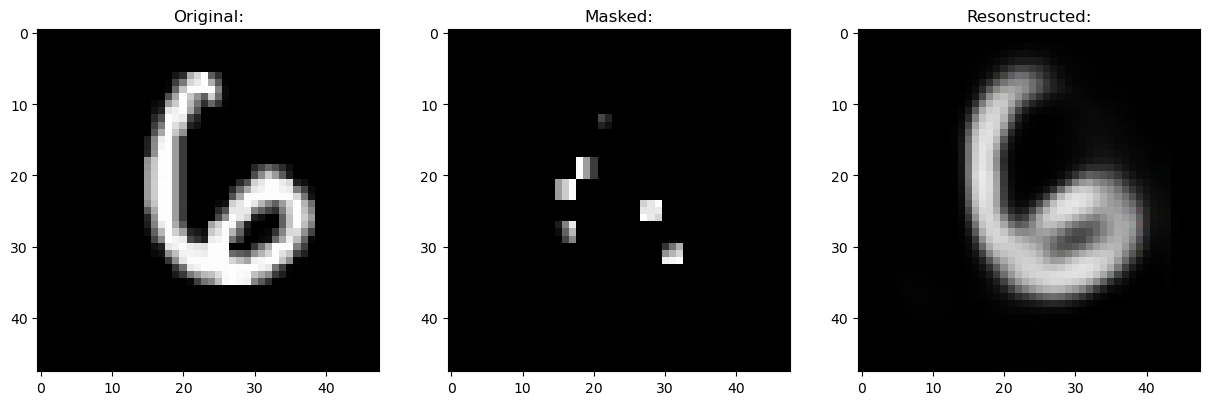

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 95s 604ms/step - loss: 0.0183 - mae: 0.0575 - val_loss: 0.0287 - val_mae: 0.0750
Epoch 37/50
157/157 [==============================] - ETA: 0s - loss: 0.0181 - mae: 0.0571 
PIMAE Start testing; got log keys: []
 

Idx chosen: 48


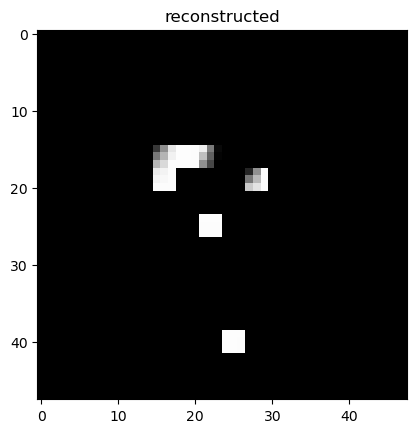

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


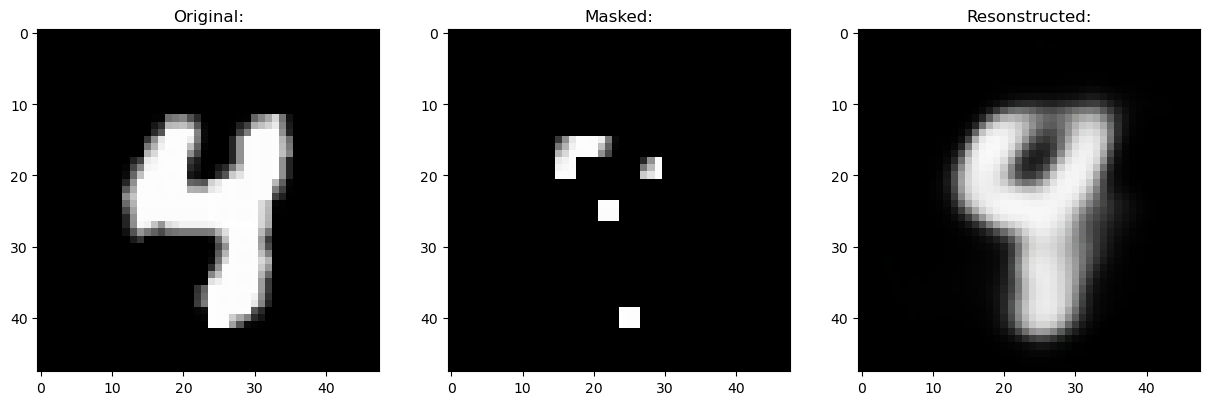

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 574ms/step - loss: 0.0181 - mae: 0.0571 - val_loss: 0.0296 - val_mae: 0.0752
Epoch 38/50
157/157 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.0565 
PIMAE Start testing; got log keys: []
 

Idx chosen: 218


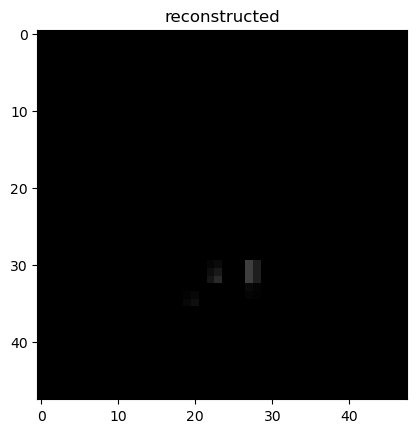

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


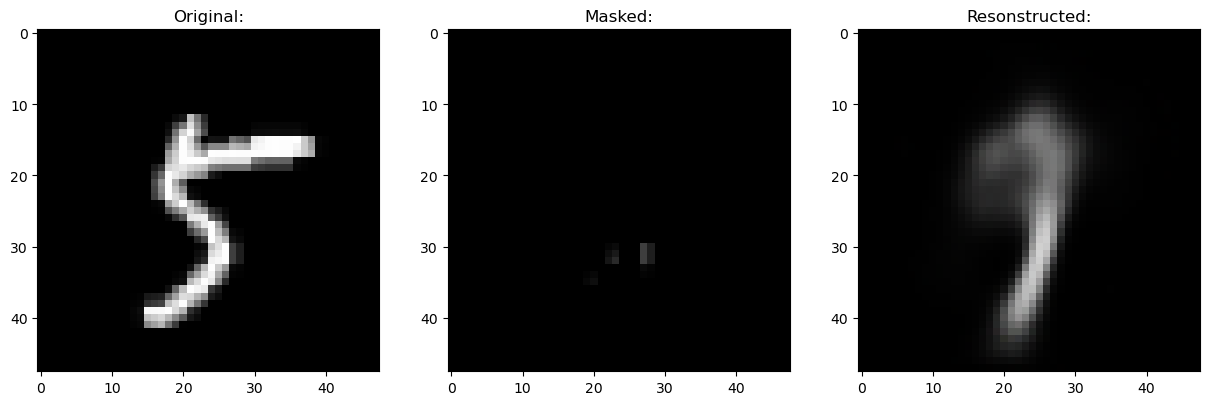

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 577ms/step - loss: 0.0179 - mae: 0.0565 - val_loss: 0.0297 - val_mae: 0.0754
Epoch 39/50
157/157 [==============================] - ETA: 0s - loss: 0.0177 - mae: 0.0560 
PIMAE Start testing; got log keys: []
 

Idx chosen: 58


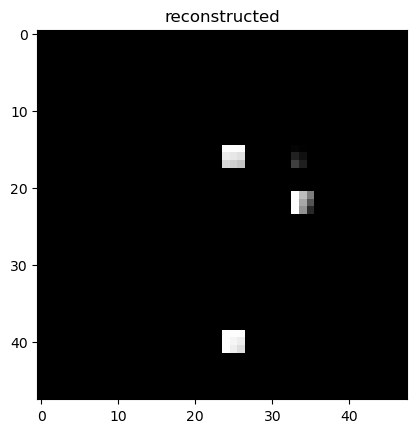

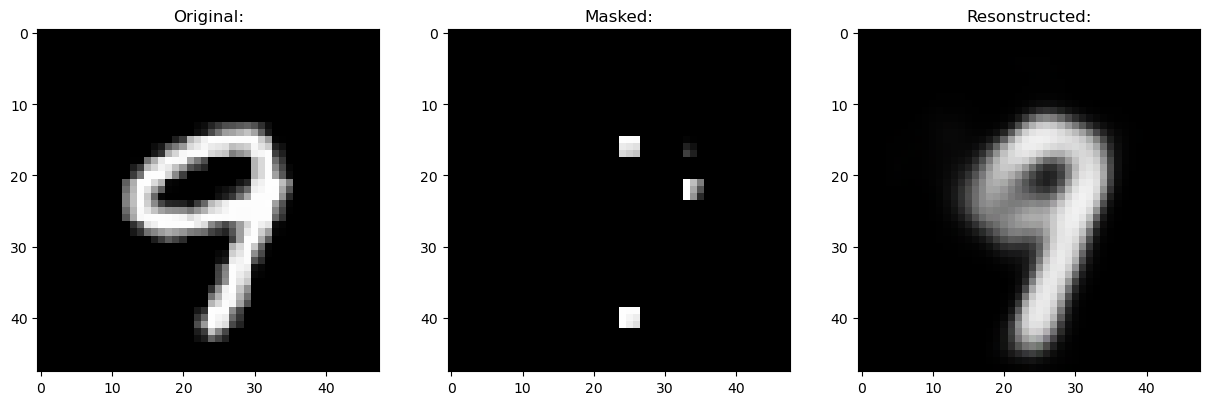

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 92s 588ms/step - loss: 0.0177 - mae: 0.0560 - val_loss: 0.0299 - val_mae: 0.0755
Epoch 40/50
157/157 [==============================] - ETA: 0s - loss: 0.0176 - mae: 0.0556 
PIMAE Start testing; got log keys: []
 

Idx chosen: 254


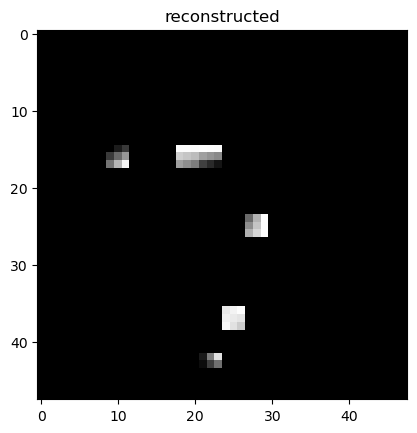

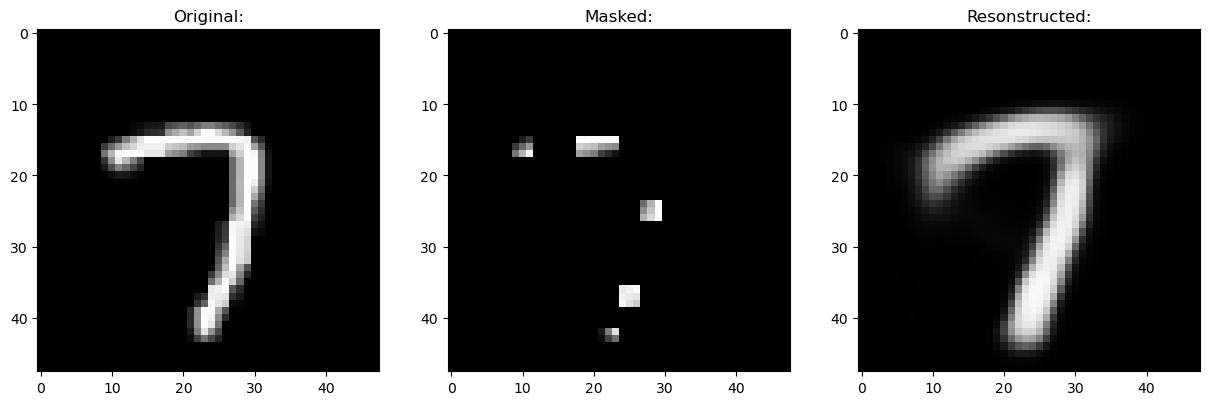

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 572ms/step - loss: 0.0176 - mae: 0.0556 - val_loss: 0.0293 - val_mae: 0.0747
Epoch 41/50
157/157 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.0550 
PIMAE Start testing; got log keys: []
 

Idx chosen: 169


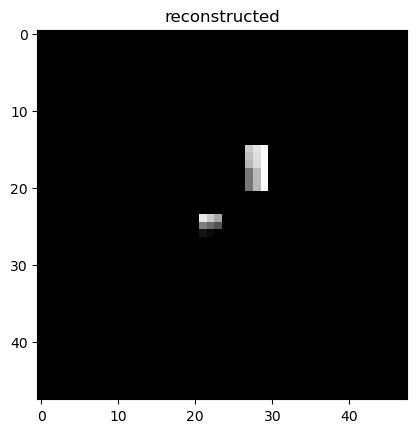

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


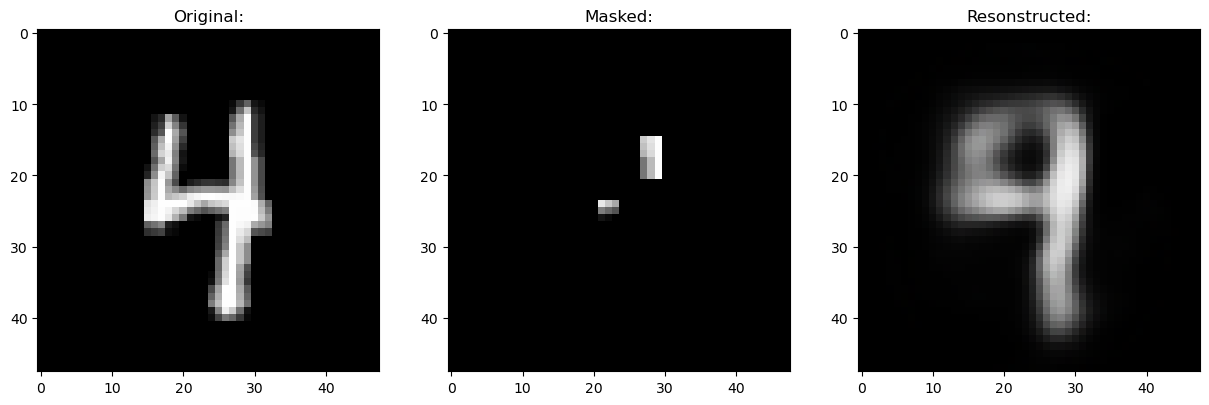

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 571ms/step - loss: 0.0173 - mae: 0.0550 - val_loss: 0.0292 - val_mae: 0.0745
Epoch 42/50
157/157 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.0550 
PIMAE Start testing; got log keys: []
 

Idx chosen: 255


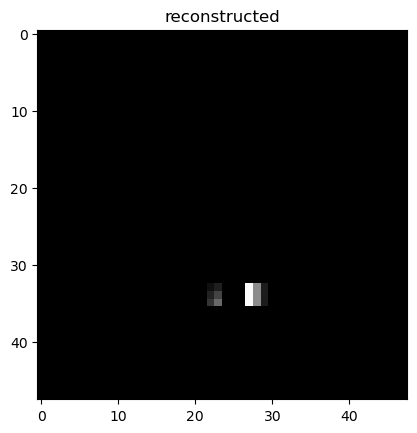

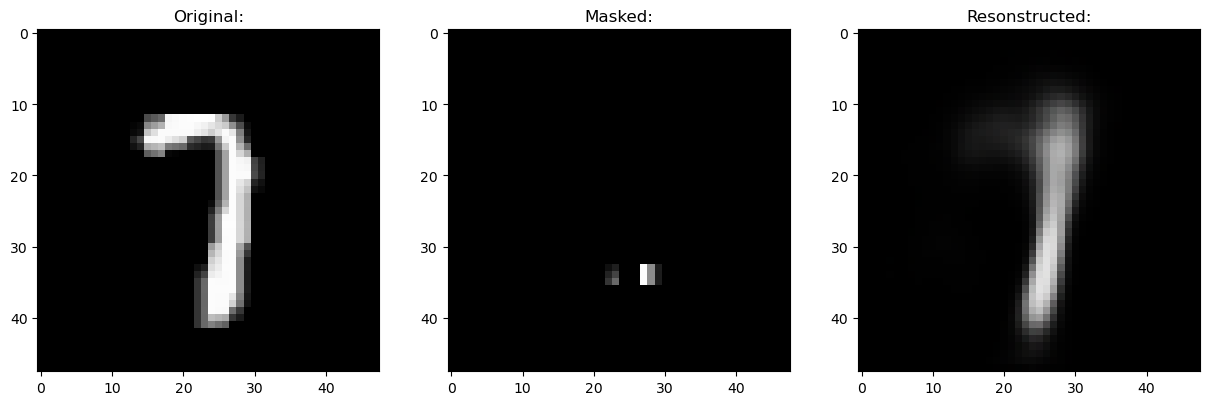

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 568ms/step - loss: 0.0173 - mae: 0.0550 - val_loss: 0.0294 - val_mae: 0.0744
Epoch 43/50
157/157 [==============================] - ETA: 0s - loss: 0.0171 - mae: 0.0546 
PIMAE Start testing; got log keys: []
 

Idx chosen: 219


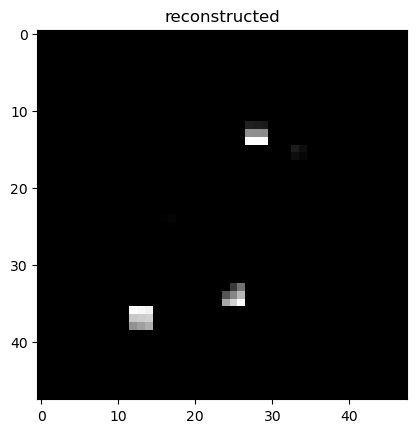

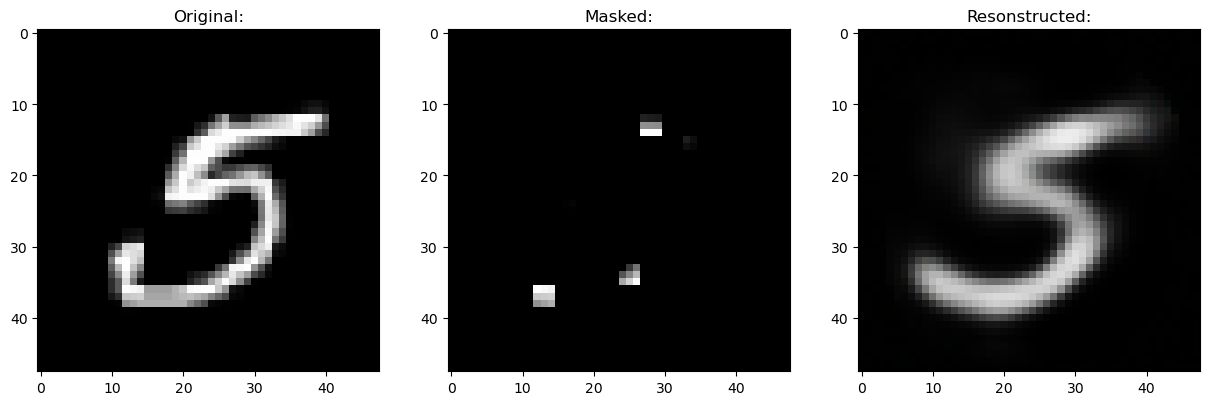

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 575ms/step - loss: 0.0171 - mae: 0.0546 - val_loss: 0.0298 - val_mae: 0.0750
Epoch 44/50
157/157 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0543 
PIMAE Start testing; got log keys: []
 

Idx chosen: 187


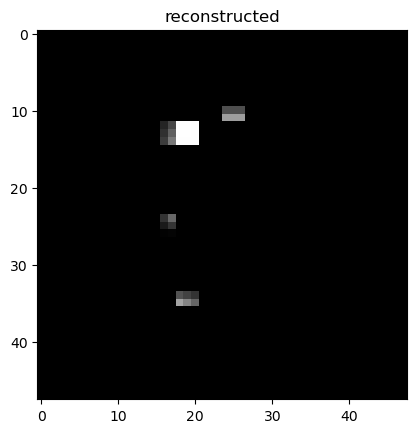

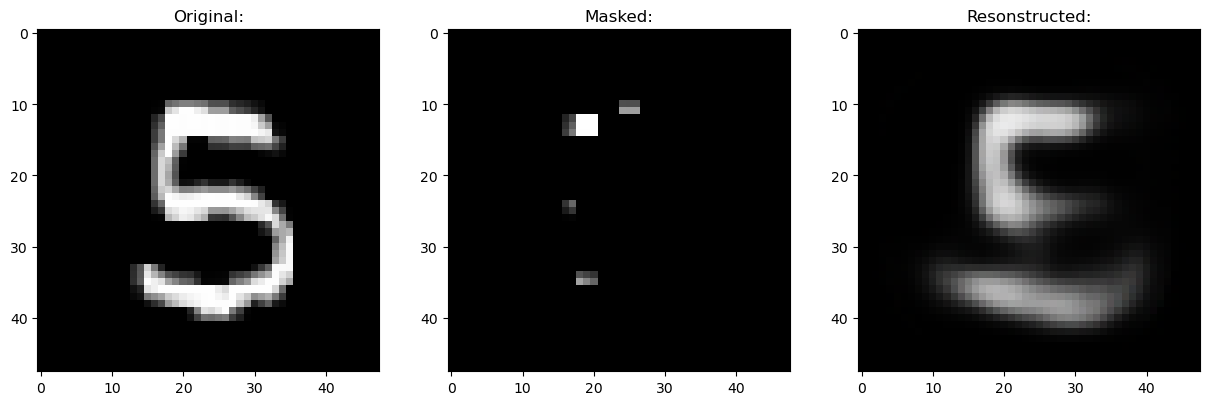

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 568ms/step - loss: 0.0170 - mae: 0.0543 - val_loss: 0.0294 - val_mae: 0.0748
Epoch 45/50
157/157 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0540 
PIMAE Start testing; got log keys: []
 

Idx chosen: 207


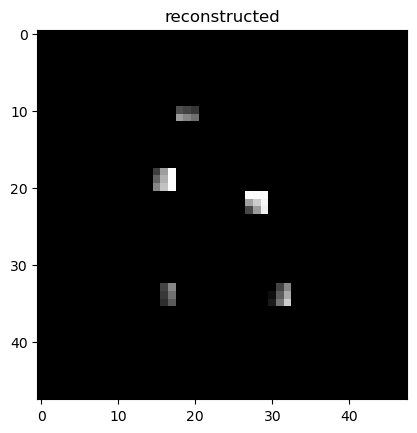

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


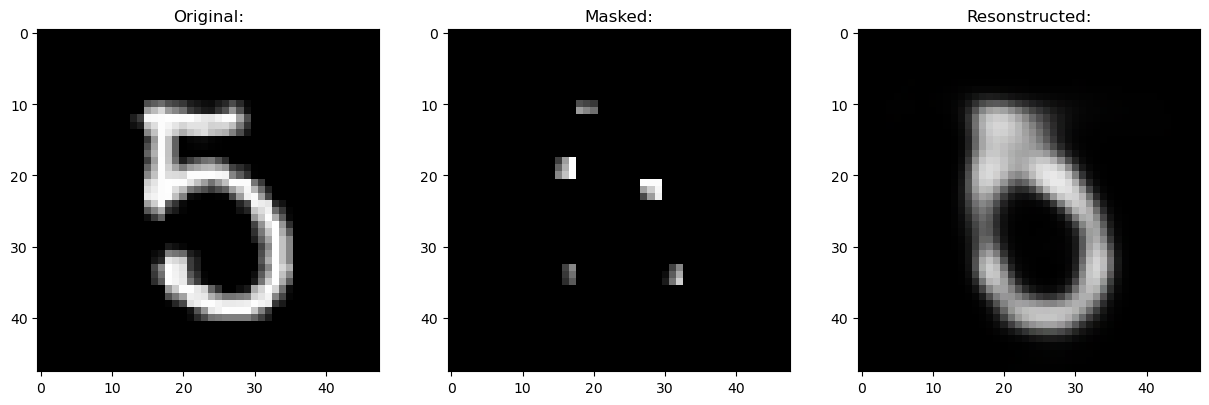

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 90s 571ms/step - loss: 0.0169 - mae: 0.0540 - val_loss: 0.0291 - val_mae: 0.0740
Epoch 46/50
157/157 [==============================] - ETA: 0s - loss: 0.0167 - mae: 0.0537

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
PIMAE Start testing; got log keys: []
 

Idx chosen: 14


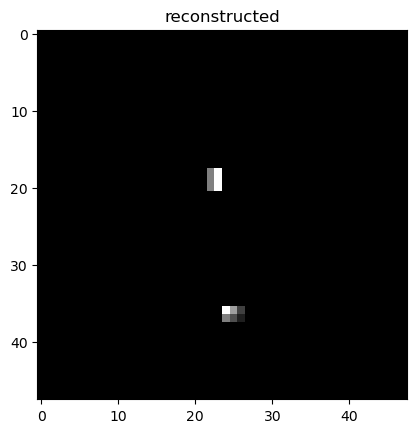

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


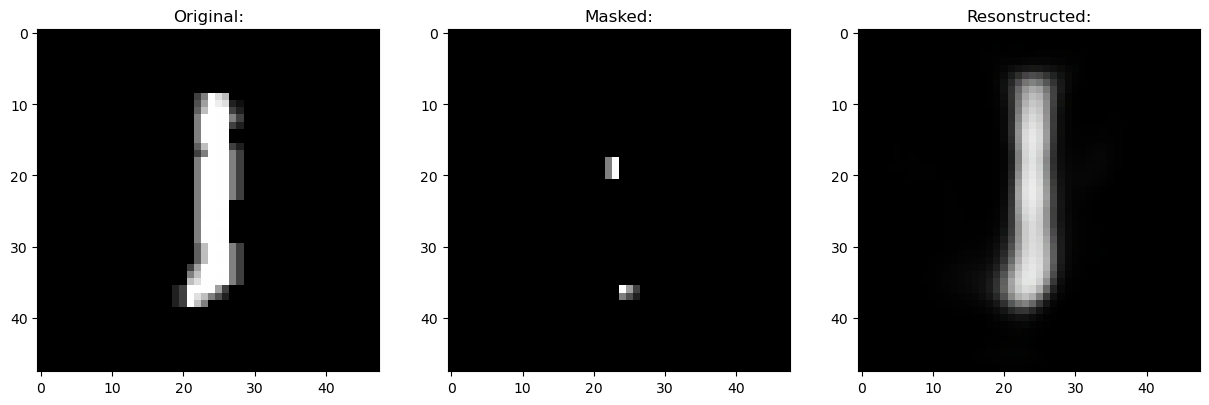

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 565ms/step - loss: 0.0167 - mae: 0.0537 - val_loss: 0.0291 - val_mae: 0.0740
Epoch 47/50
157/157 [==============================] - ETA: 0s - loss: 0.0167 - mae: 0.0539 
PIMAE Start testing; got log keys: []
 

Idx chosen: 189


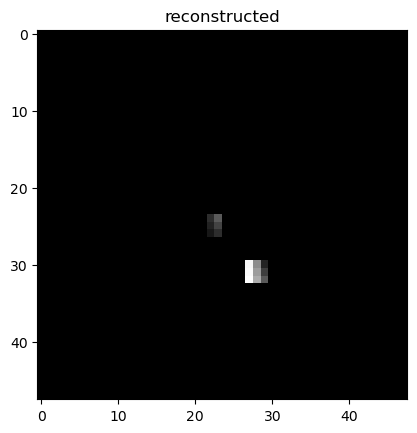

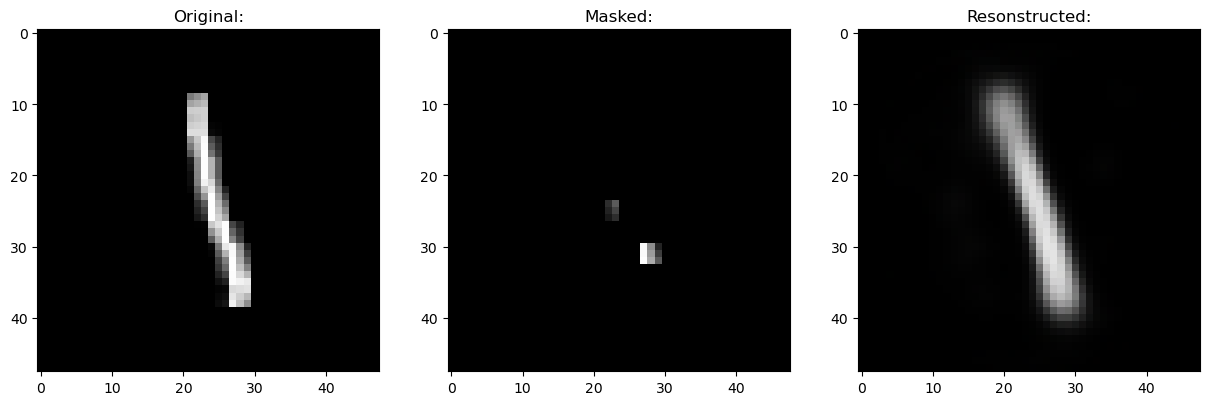

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 89s 565ms/step - loss: 0.0167 - mae: 0.0539 - val_loss: 0.0294 - val_mae: 0.0747
Epoch 48/50
157/157 [==============================] - ETA: 0s - loss: 0.0168 - mae: 0.0542 
PIMAE Start testing; got log keys: []
 

Idx chosen: 189


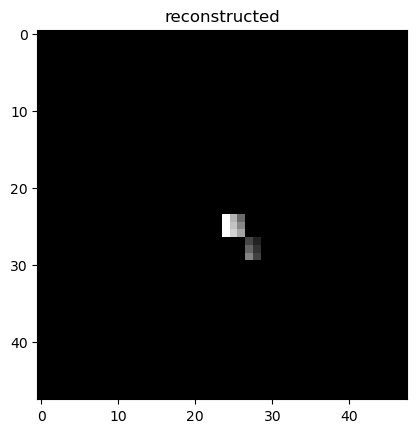

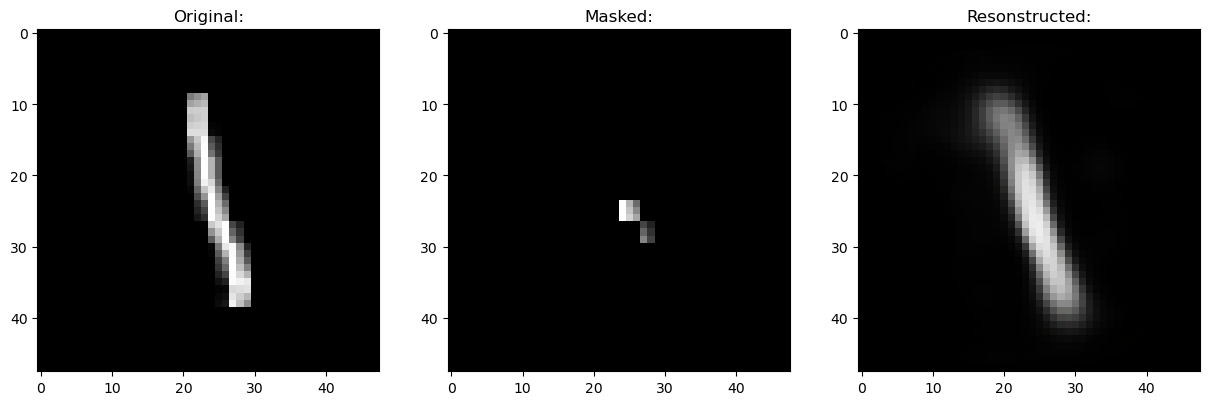

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 561ms/step - loss: 0.0168 - mae: 0.0542 - val_loss: 0.0295 - val_mae: 0.0751
Epoch 49/50
157/157 [==============================] - ETA: 0s - loss: 0.0168 - mae: 0.0547 
PIMAE Start testing; got log keys: []
 

Idx chosen: 174


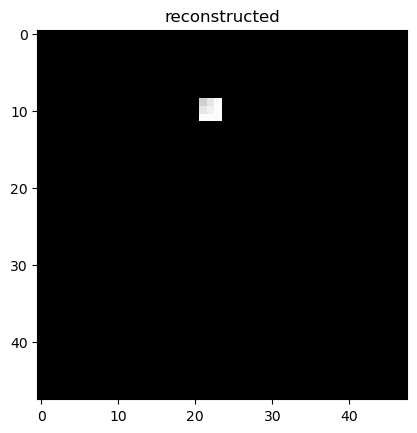

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


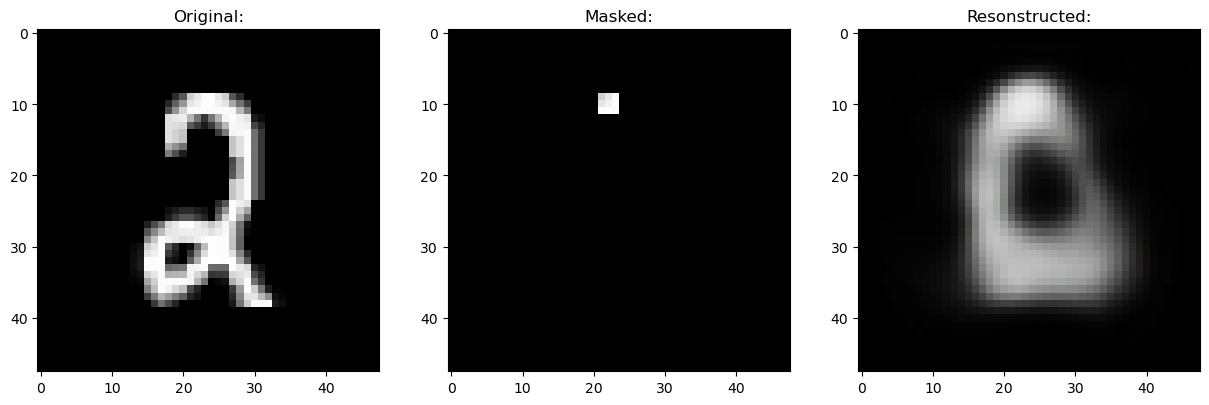

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
157/157 [==============================] - 88s 563ms/step - loss: 0.0168 - mae: 0.0547 - val_loss: 0.0293 - val_mae: 0.0755
Epoch 50/50
157/157 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0558 
PIMAE Start testing; got log keys: []
 

Idx chosen: 189


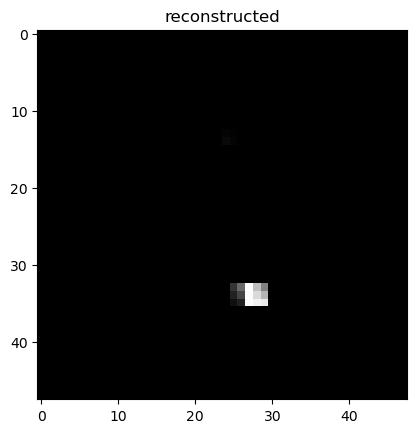

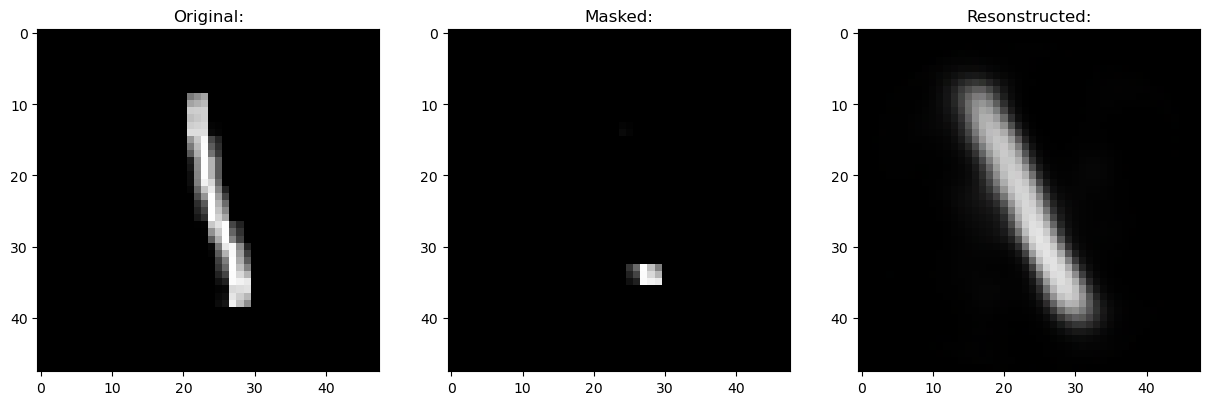

 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
40/40 [==============================] - 6s 147ms/step - loss: 0.0295 - mae: 0.0773
Loss: 0.03
MAE: 0.08


In [18]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
pimae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = pimae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[PIMAECustomCallback()],
)
loss, mae = pimae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

 
PIMAE Start testing; got log keys: []
 

Idx chosen: 50


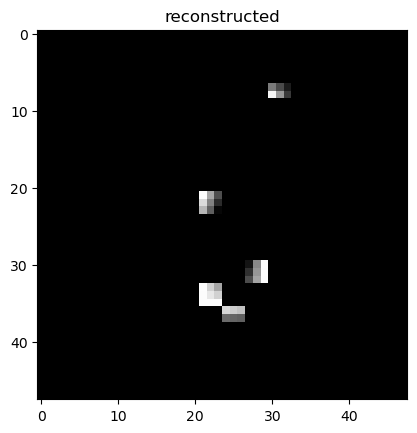

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


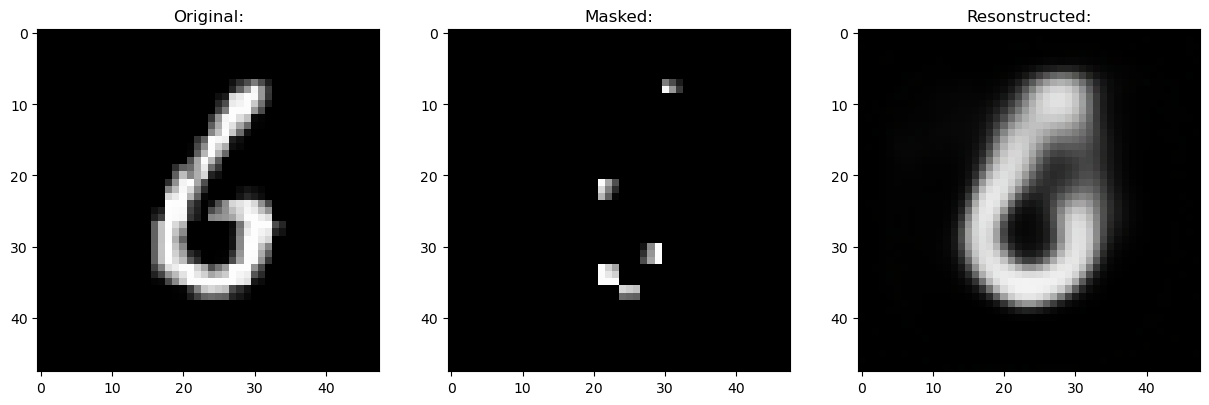

40/40 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.0771 
PIMAE Stop testing; got log keys: ['loss', 'mae']
 
40/40 [==============================] - 6s 147ms/step - loss: 0.0294 - mae: 0.0771
Loss: 0.03
MAE: 0.08


In [19]:
loss, mae = pimae_model.evaluate(test_ds, callbacks=[PIMAECustomCallback()])
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

In [20]:
patch_encoder.alreadyMasked = True  # Swtich the downstream flag to True.

In [21]:
test_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None)>

In [22]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [23]:
import numpy as np

def rescale_image(image):
    # Ensure image data is in floating-point format for accurate scaling
    image = image.astype(np.float32)

    # Find the minimum and maximum pixel values in the image
    min_value = np.min(image)
    max_value = np.max(image)

    # Rescale the image to have pixel values ranging from 0 to 255
    rescaled_image = 255.0 * (image - min_value) / (max_value - min_value)

    # Convert the rescaled image back to integer format (0 to 255)
    rescaled_image = rescaled_image.astype(np.uint8)

    return rescaled_image

# Example usage:
# Assuming you have an image loaded into 'image_array'
# rescaled_image = rescale_image(image_array)


In [24]:
class PIMAEBlockCustomCallback(keras.callbacks.Callback):

    def on_test_begin(self, logs=None):

        print('Changed the PIMAE Callback after training')

        test_augmented_images = self.model.test_augmentation_model(test_images)
        test_patches = self.model.patch_layer(test_augmented_images)
        (
            test_unmasked_embeddings,
            test_masked_embeddings,
            test_unmasked_positions,
            test_mask_indices,
            test_unmask_indices,
        ) = self.model.patch_encoder(test_patches)
        test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
        test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
        test_decoder_inputs = tf.concat(
            [test_encoder_outputs, test_masked_embeddings], axis=1
        )
        test_decoder_outputs = self.model.decoder(test_decoder_inputs)
        test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
            test_patches, test_unmask_indices
        )
        original_image = test_augmented_images[idx]
        masked_image = self.model.patch_layer.reconstruct_from_patch(
            test_masked_patch
        )
        reconstructed_image = test_decoder_outputs[idx]
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        ax[0].imshow(img_mask, cmap='gray')
        ax[0].set_title(f"Scan Pattern:")

        ax[1].imshow(img, cmap='gray')
        ax[1].set_title(f"Input Image:")

        ax[2].imshow(reconstructed_image, cmap='gray')
        ax[2].set_title(f"Resonstructed:")

        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        fig_path = os.path.join(os.getcwd(), f'PI-MAE-Scans/Results-From-Running-Model/90-Physical-Results/{fig_fn}')
        plt.savefig(fig_path, dpi=150)
        plt.show()
        plt.close()

mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/X-90-1-23-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


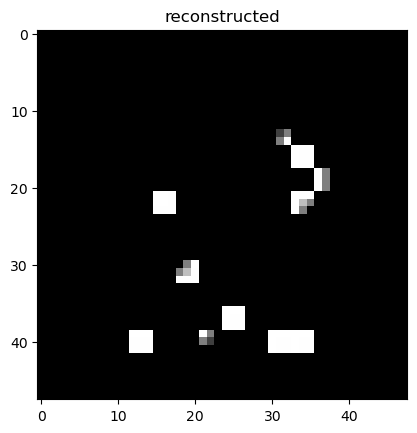

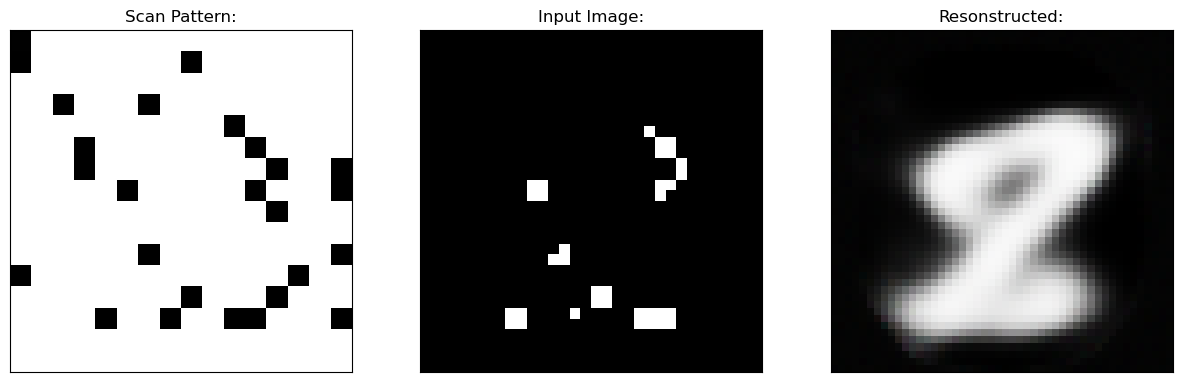

40/40 [==============================] - 6s 144ms/step - loss: 0.0271 - mae: 0.0708
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/E-90-1-4-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


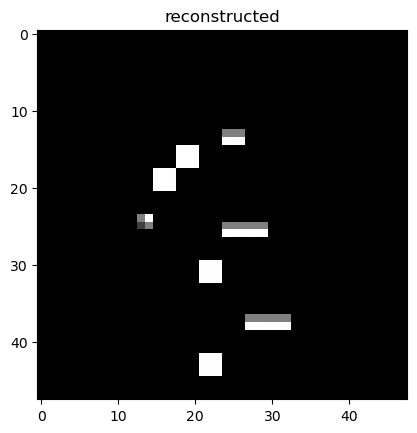

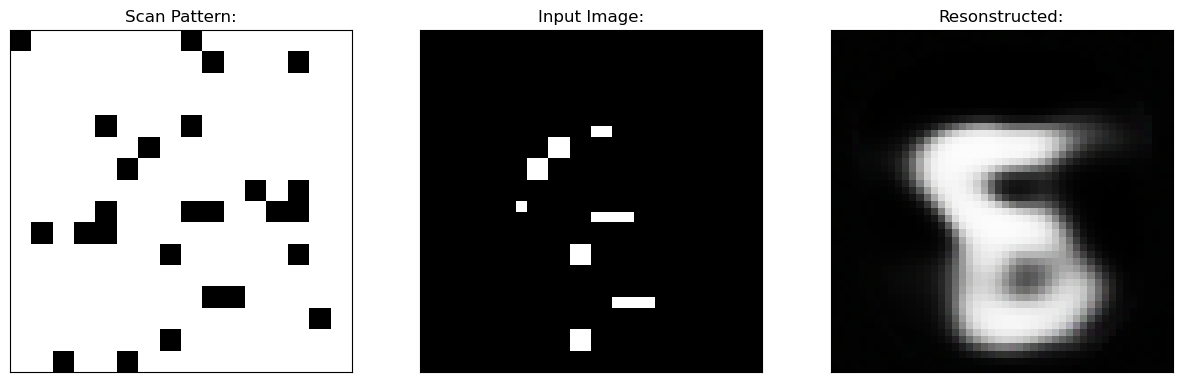

40/40 [==============================] - 6s 145ms/step - loss: 0.0244 - mae: 0.0662
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/M-90-1-19-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


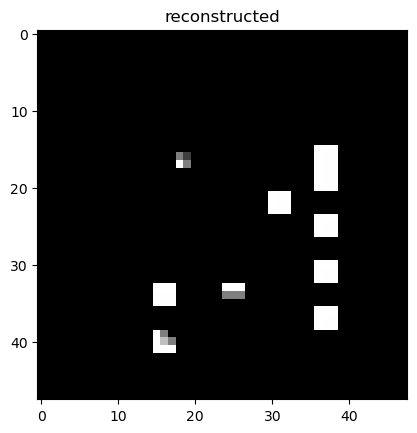

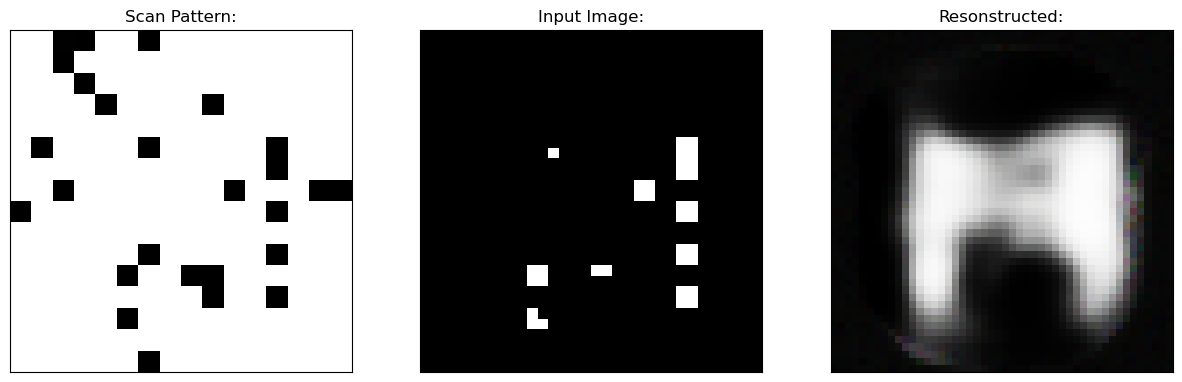

40/40 [==============================] - 6s 144ms/step - loss: 0.0256 - mae: 0.0685
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/P-90-1-34-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


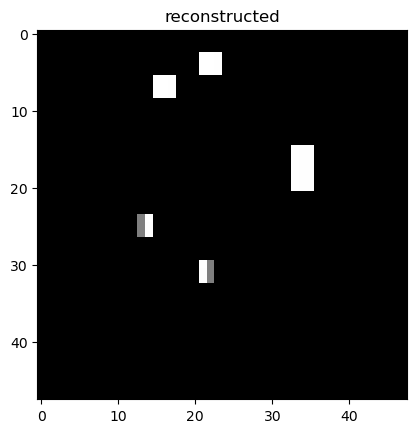

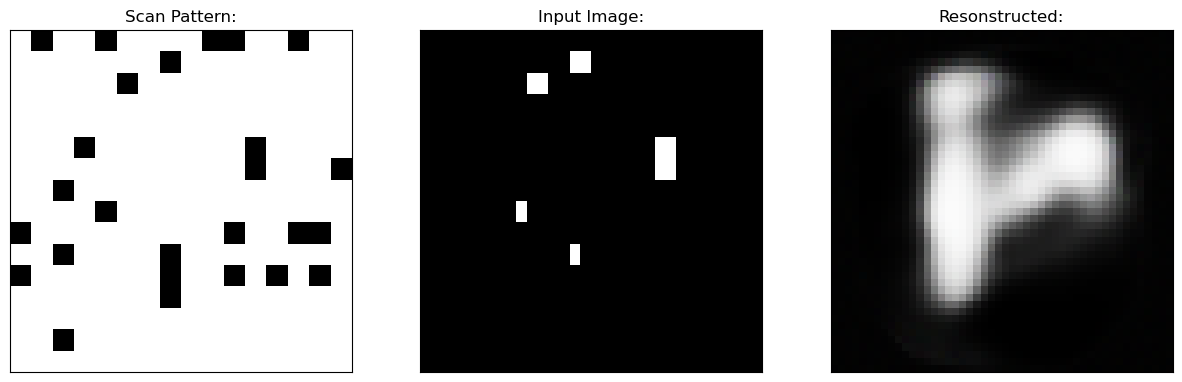

40/40 [==============================] - 6s 144ms/step - loss: 0.0307 - mae: 0.0793
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/9-90-1-15-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


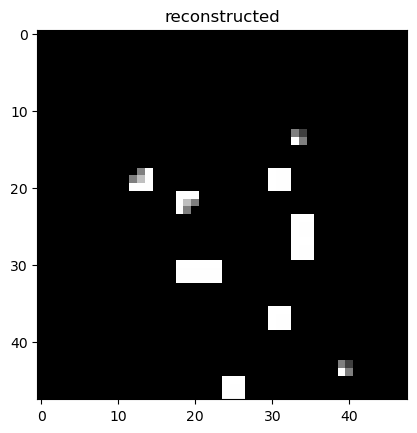

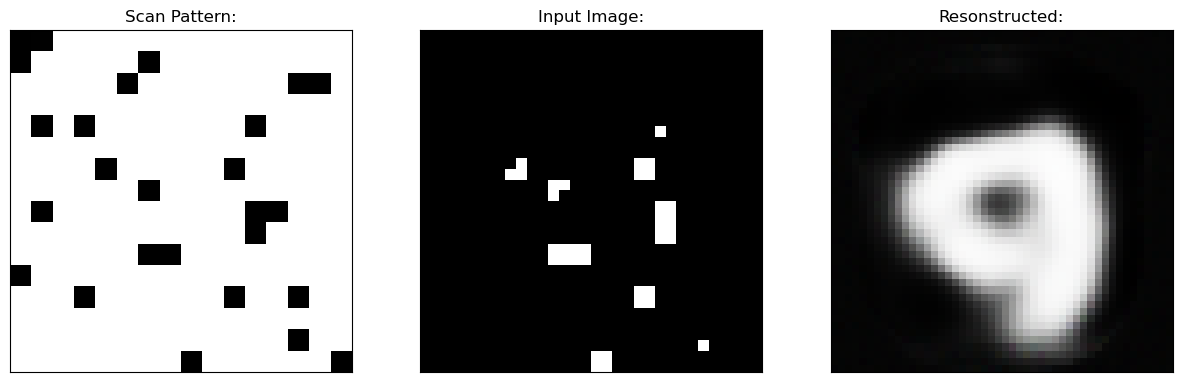

40/40 [==============================] - 6s 144ms/step - loss: 0.0273 - mae: 0.0737
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/Q-90-1-10-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


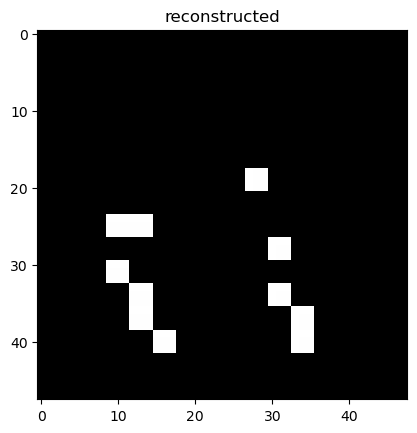

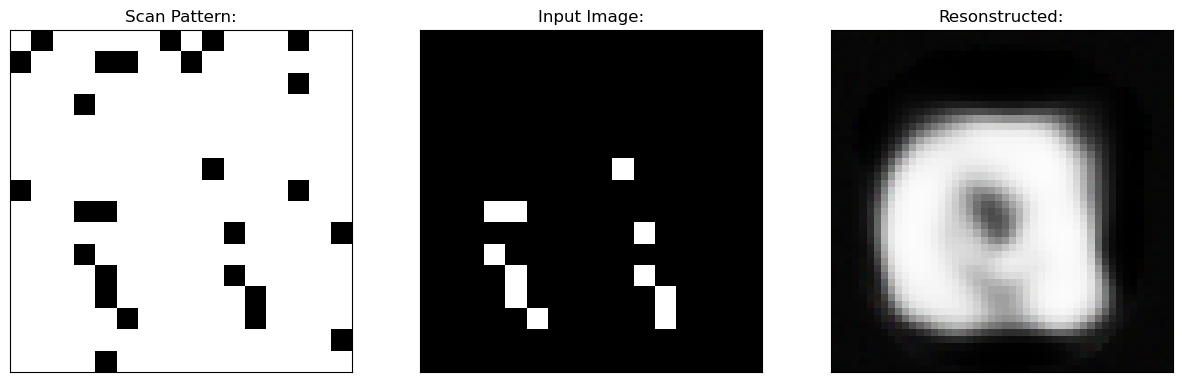

40/40 [==============================] - 6s 144ms/step - loss: 0.0341 - mae: 0.0875
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/6-90-1-14-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


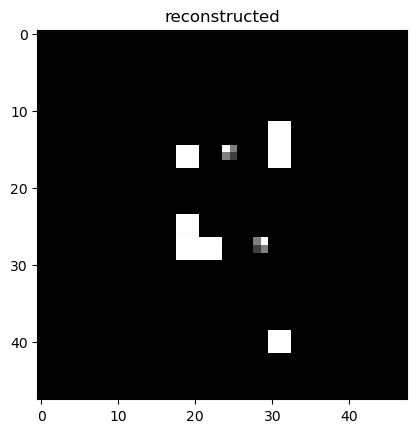

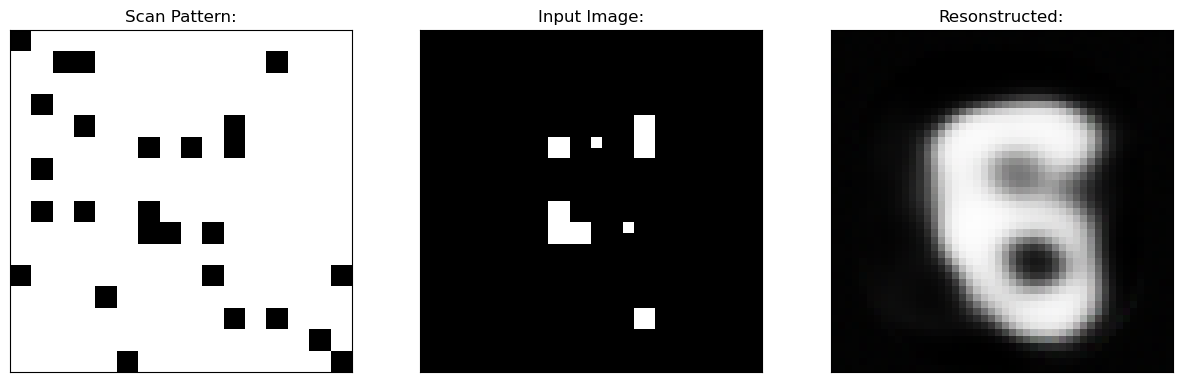

40/40 [==============================] - 6s 146ms/step - loss: 0.0248 - mae: 0.0698
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/C-90-1-3-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


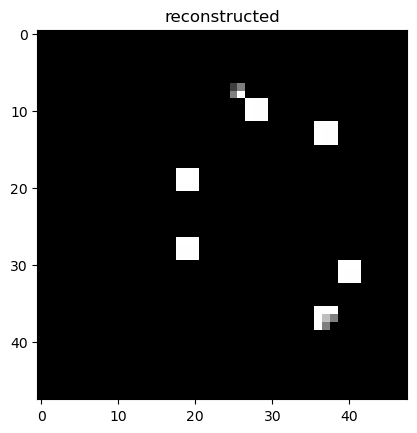

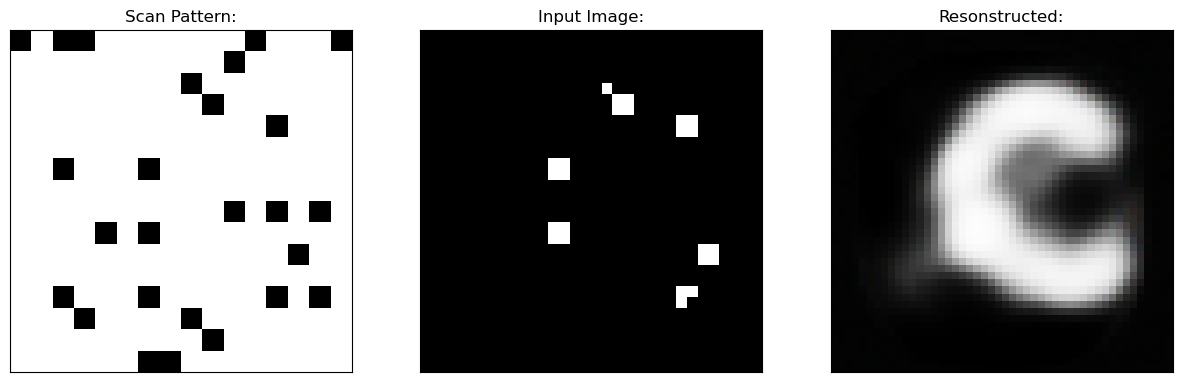

40/40 [==============================] - 6s 144ms/step - loss: 0.0265 - mae: 0.0712
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/D-90-1-24-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


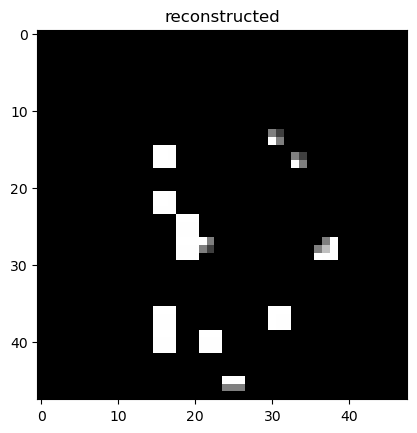

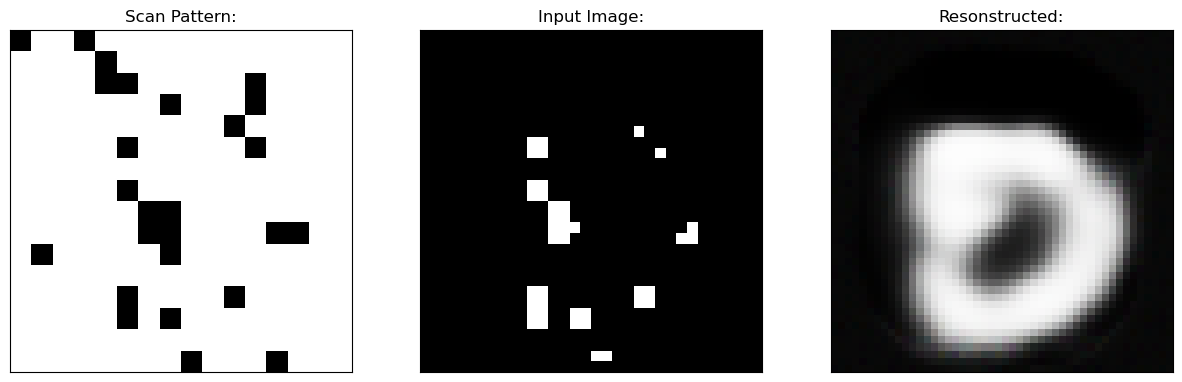

40/40 [==============================] - 6s 146ms/step - loss: 0.0226 - mae: 0.0632
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/Z-90-1-8-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


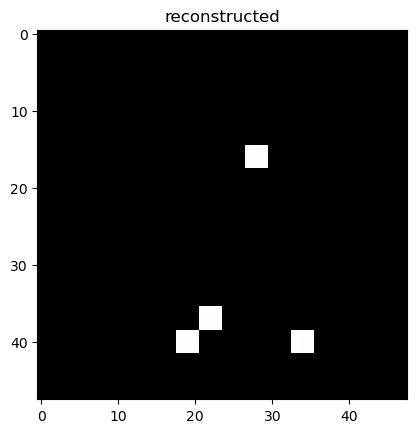

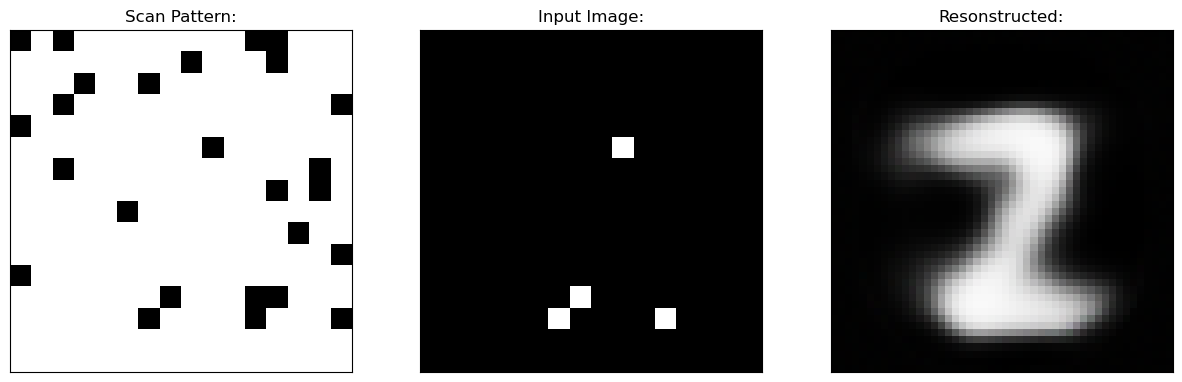

40/40 [==============================] - 6s 145ms/step - loss: 0.0372 - mae: 0.0908
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/7-90-1-12-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


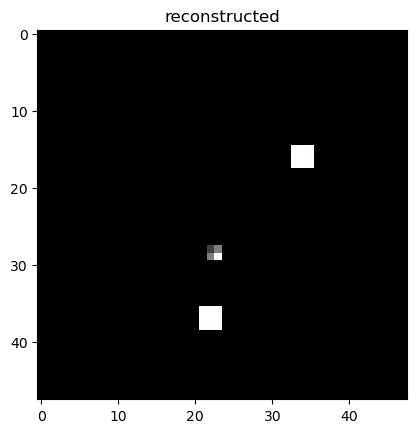

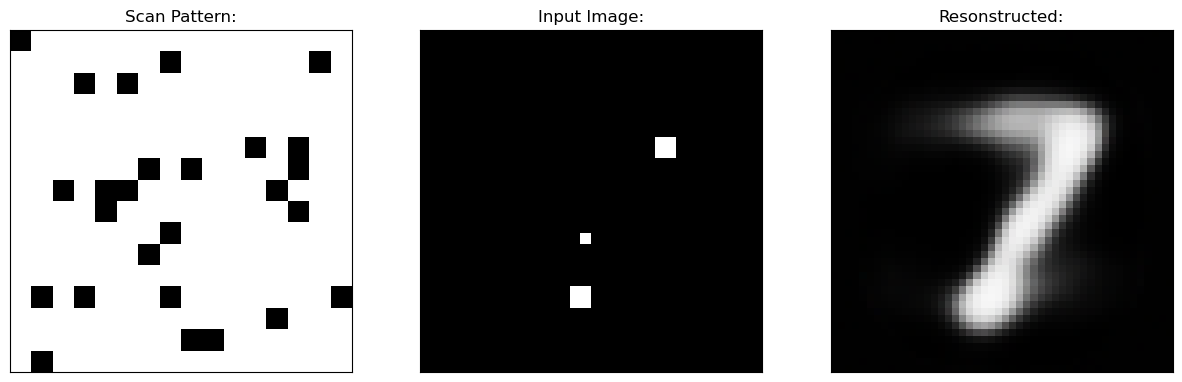

40/40 [==============================] - 6s 145ms/step - loss: 0.0267 - mae: 0.0726
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/A-90-1-26-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


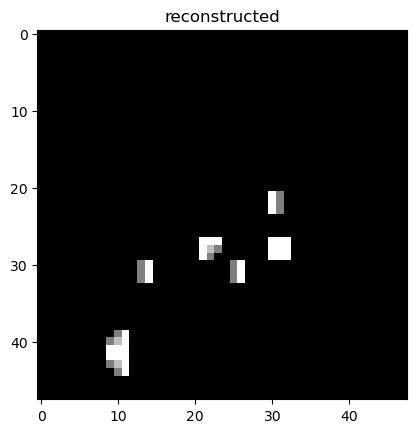

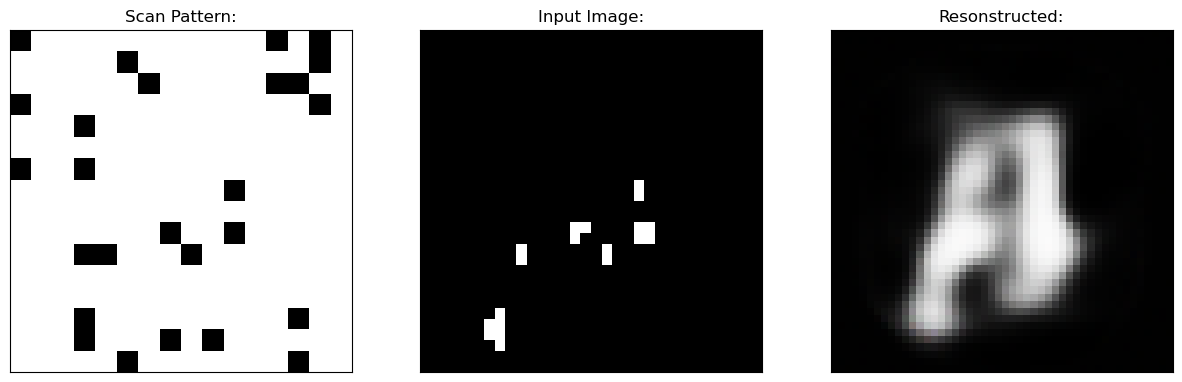

40/40 [==============================] - 6s 145ms/step - loss: 0.0336 - mae: 0.0851
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/B-90-1-16-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


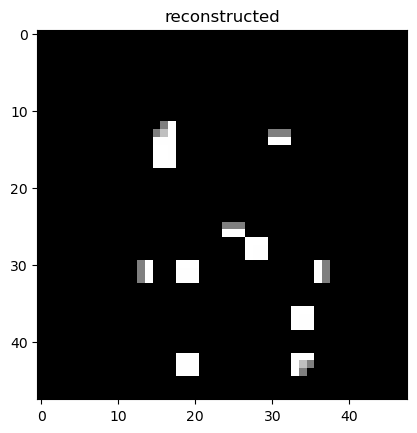

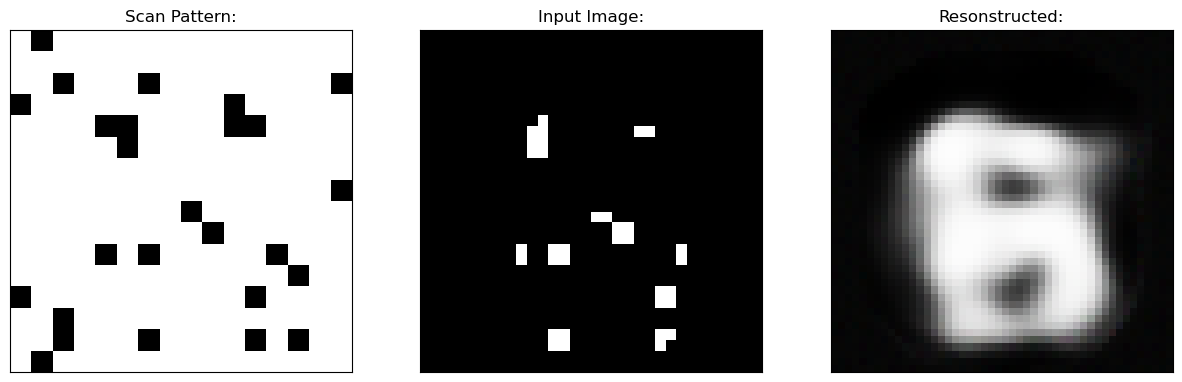

40/40 [==============================] - 6s 145ms/step - loss: 0.0277 - mae: 0.0728
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/2-90-1-6-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


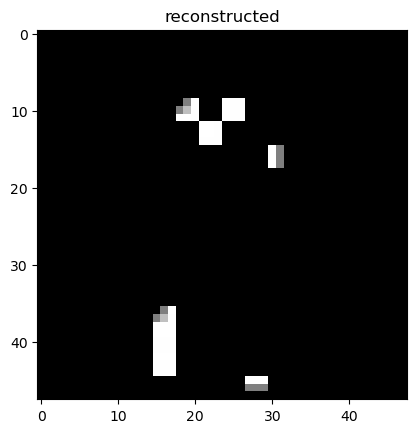

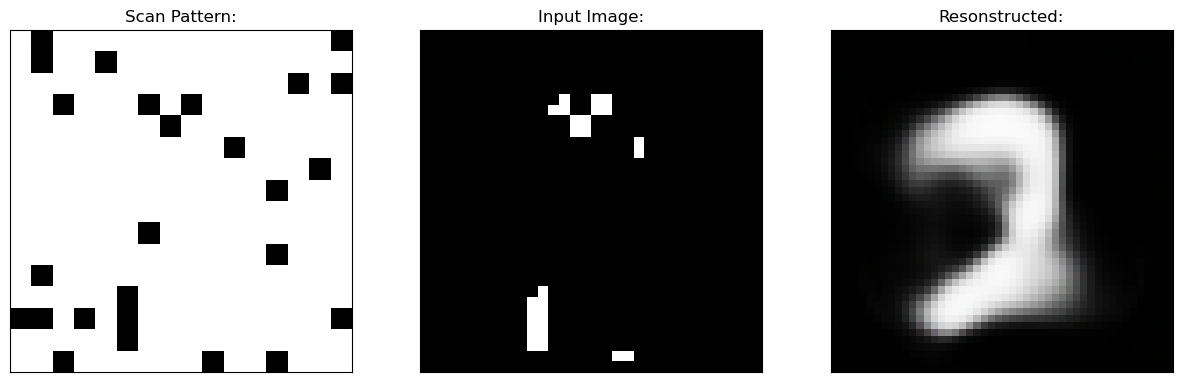

40/40 [==============================] - 6s 144ms/step - loss: 0.0325 - mae: 0.0845
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/8-90-1-9-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


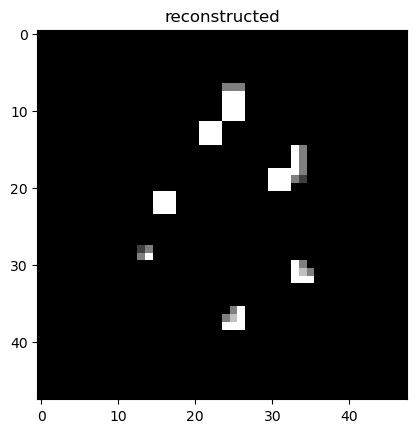

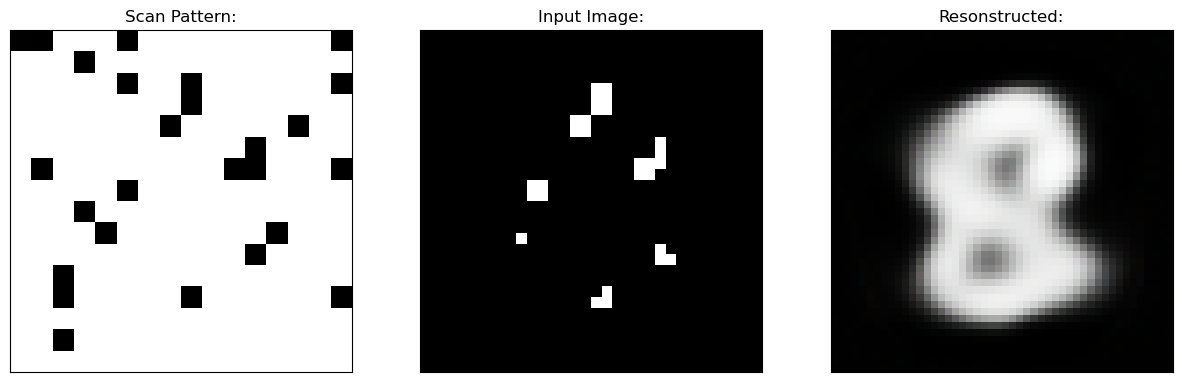

40/40 [==============================] - 6s 144ms/step - loss: 0.0295 - mae: 0.0745
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/3-90-1-17-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


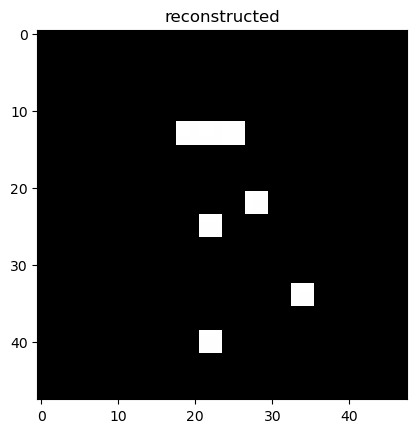

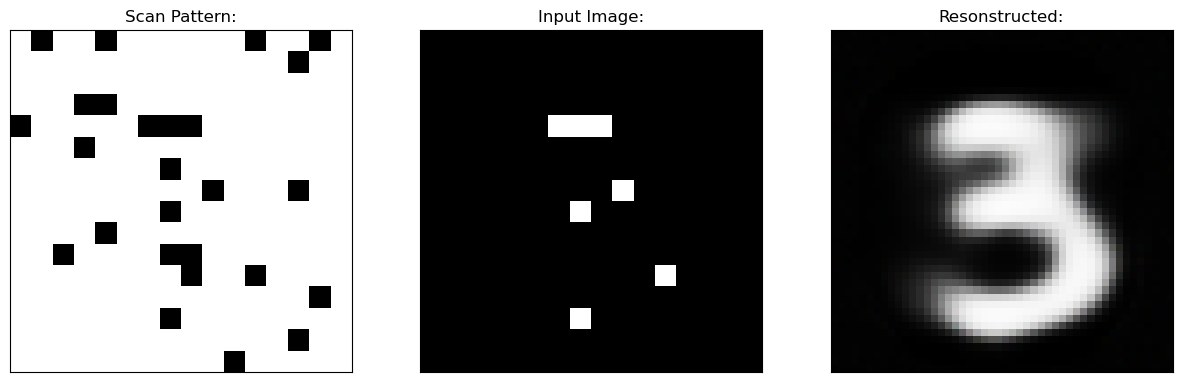

40/40 [==============================] - 6s 144ms/step - loss: 0.0231 - mae: 0.0660
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/1-90-1-3-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


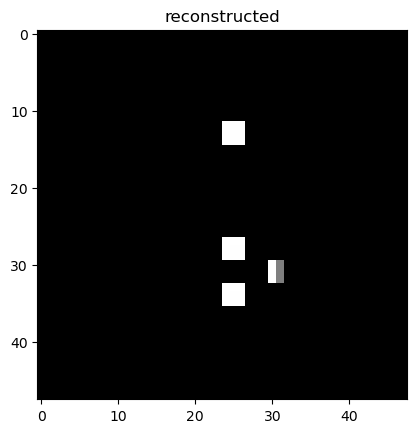

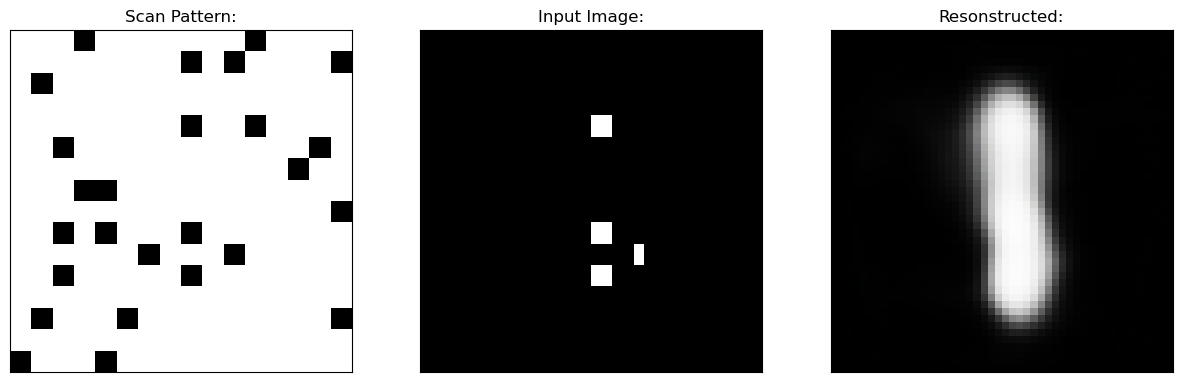

40/40 [==============================] - 6s 145ms/step - loss: 0.0268 - mae: 0.0719
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/5-90-1-6-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


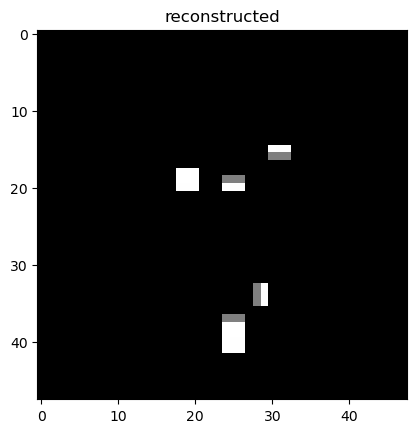

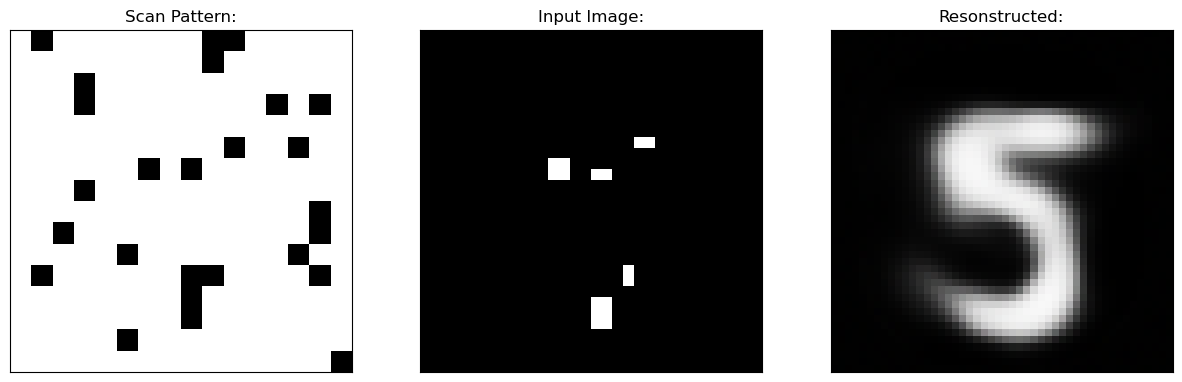

40/40 [==============================] - 6s 144ms/step - loss: 0.0284 - mae: 0.0740
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/V-90-1-30-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


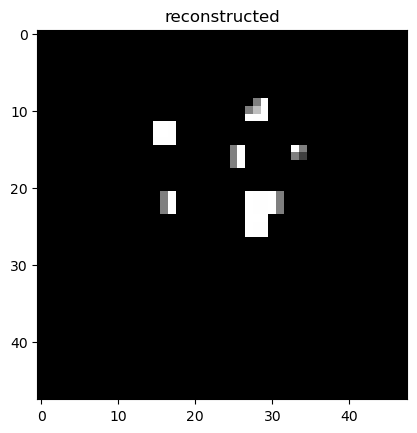

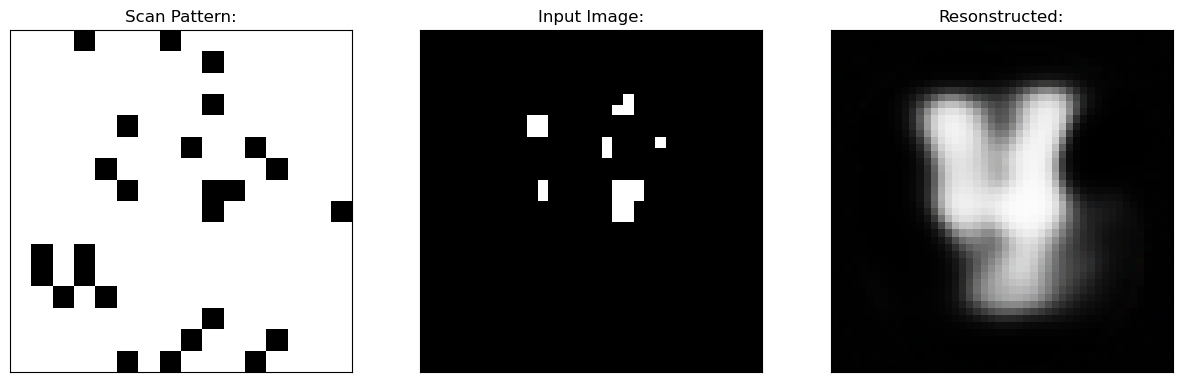

40/40 [==============================] - 6s 144ms/step - loss: 0.0268 - mae: 0.0718
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/H-90-1-8-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


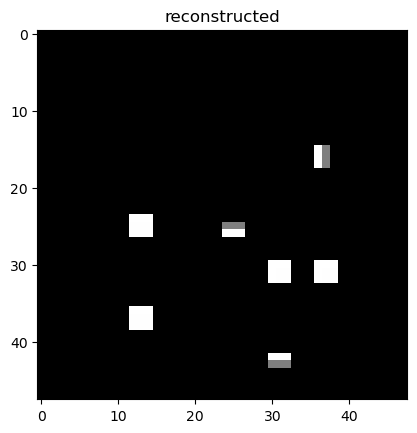

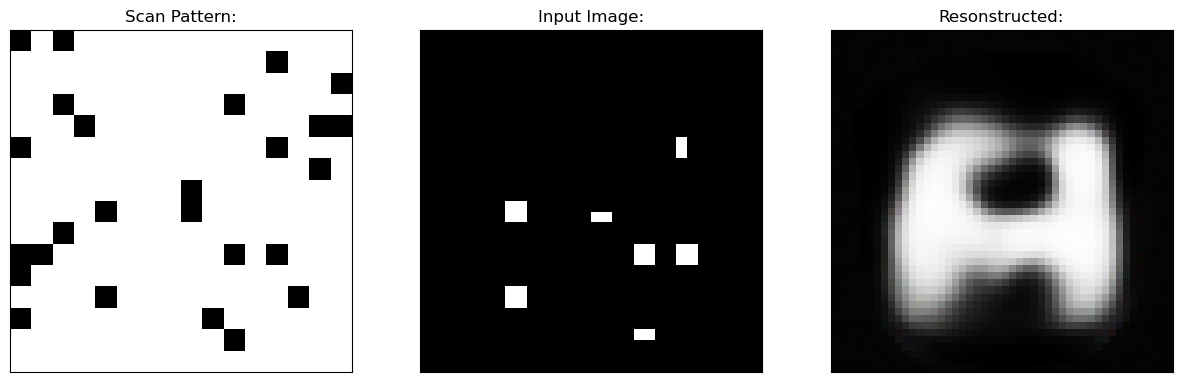

40/40 [==============================] - 6s 144ms/step - loss: 0.0317 - mae: 0.0822
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/W-90-1-49-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


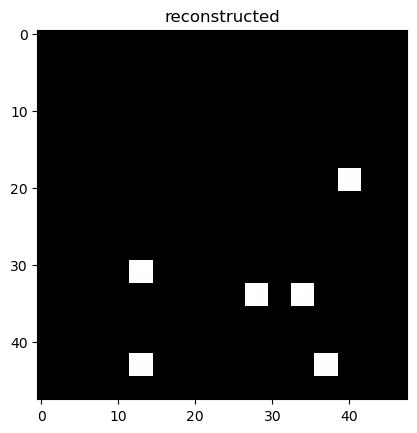

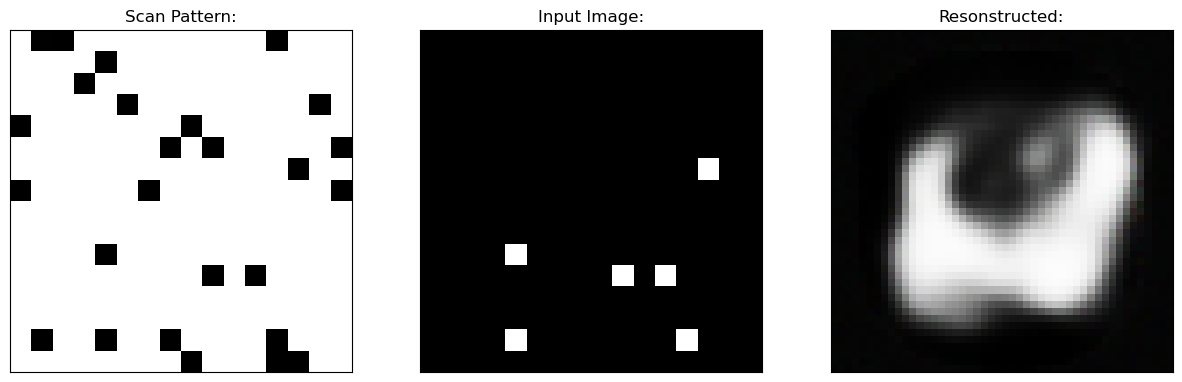

40/40 [==============================] - 6s 144ms/step - loss: 0.0308 - mae: 0.0801
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/F-90-1-26-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


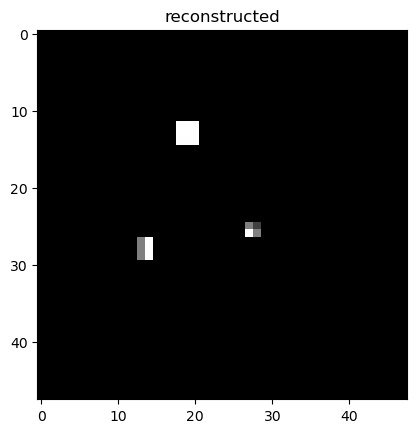

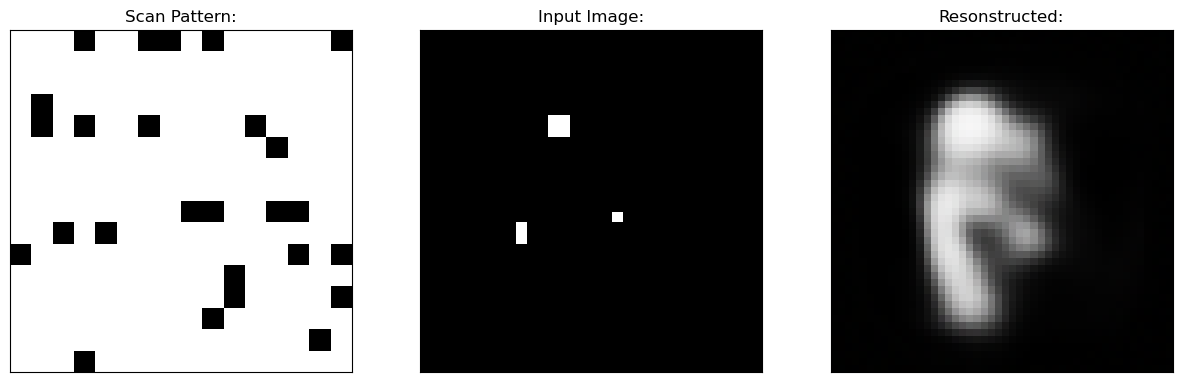

40/40 [==============================] - 6s 145ms/step - loss: 0.0311 - mae: 0.0792
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/4-90-1-3-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


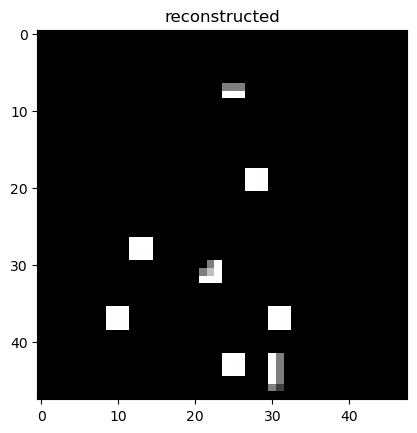

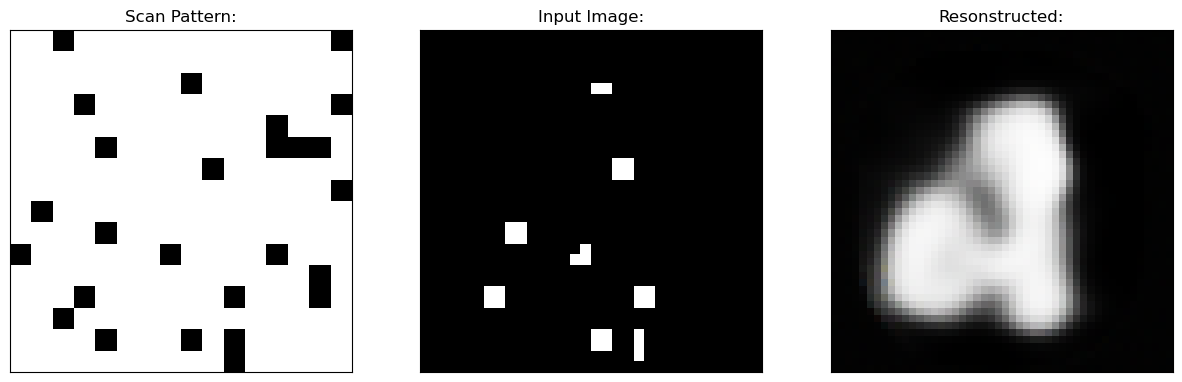

40/40 [==============================] - 6s 145ms/step - loss: 0.0318 - mae: 0.0806
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/R-90-1-3-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


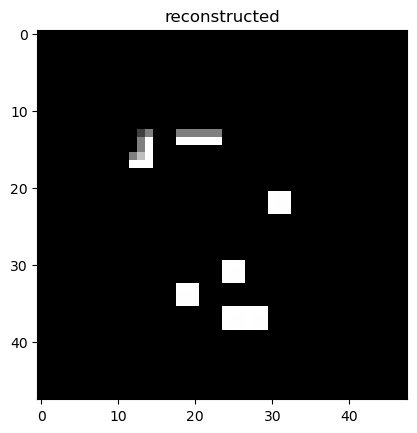

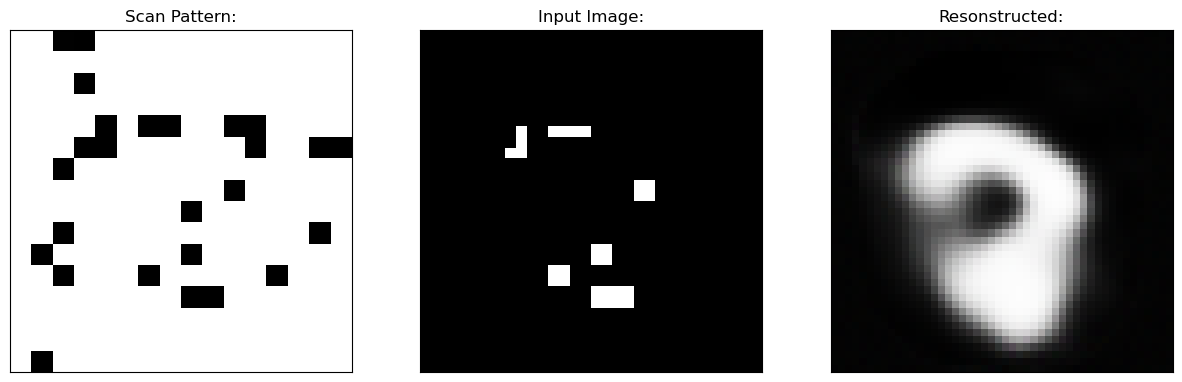

40/40 [==============================] - 6s 144ms/step - loss: 0.0248 - mae: 0.0660
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/K-90-1-47-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


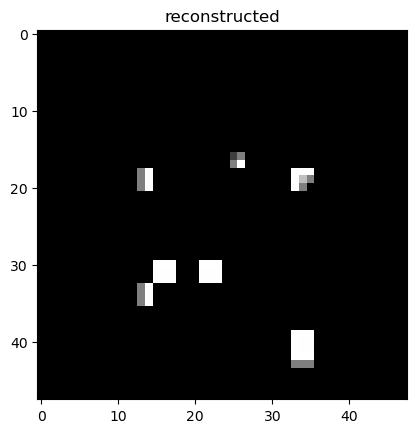

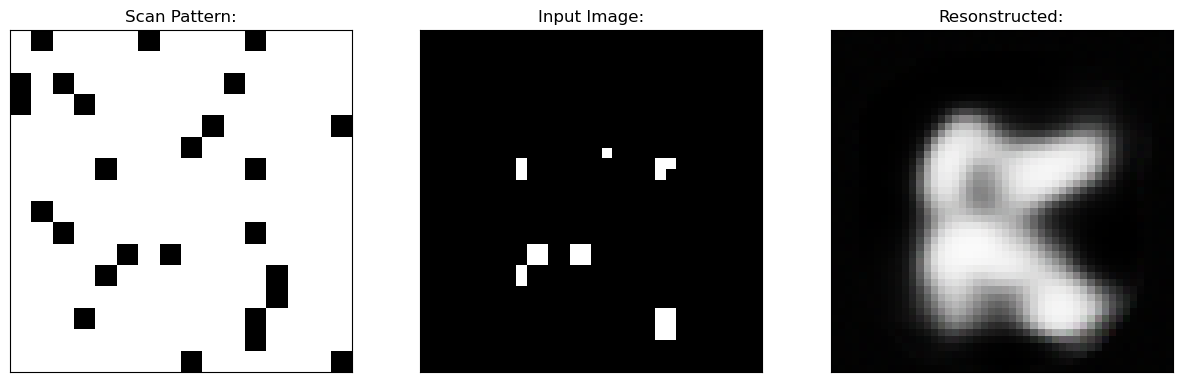

40/40 [==============================] - 6s 145ms/step - loss: 0.0278 - mae: 0.0734
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/L-90-1-26-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


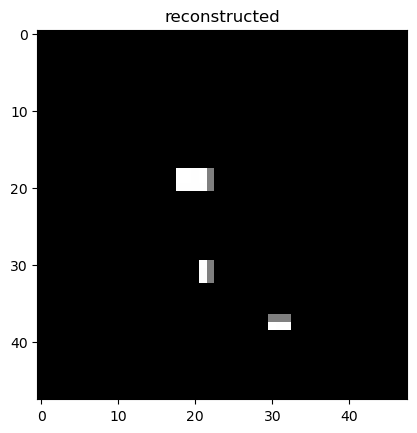

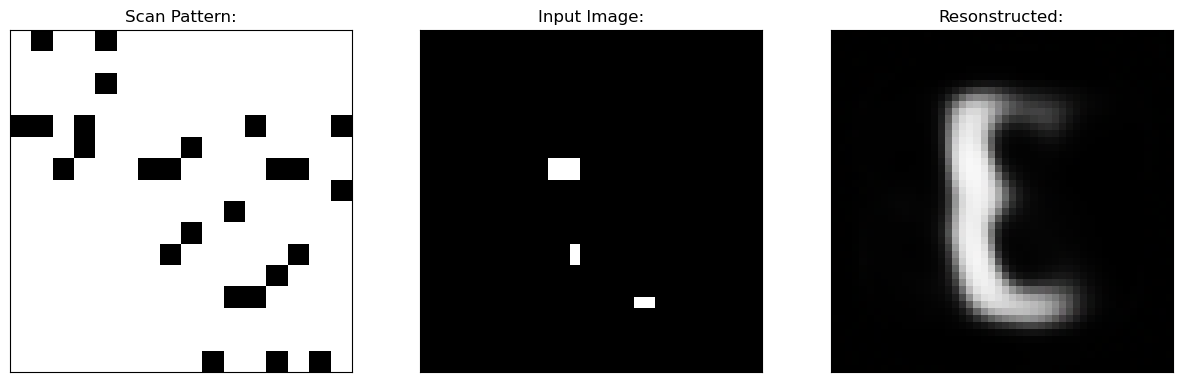

40/40 [==============================] - 6s 145ms/step - loss: 0.0272 - mae: 0.0745
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/I-90-1-3-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


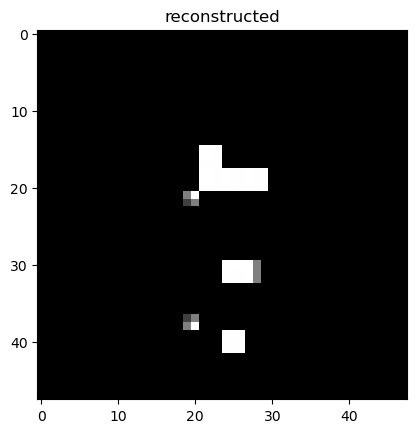

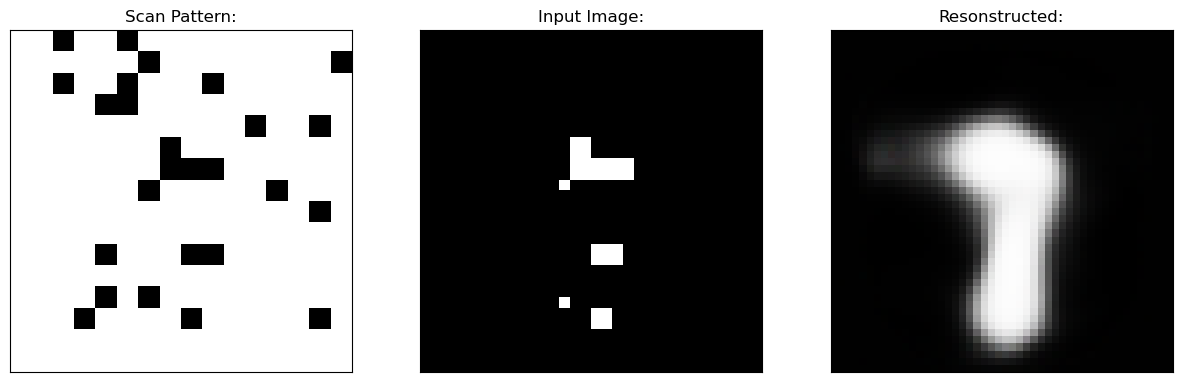

40/40 [==============================] - 6s 145ms/step - loss: 0.0235 - mae: 0.0652
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/O-90-1-6-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


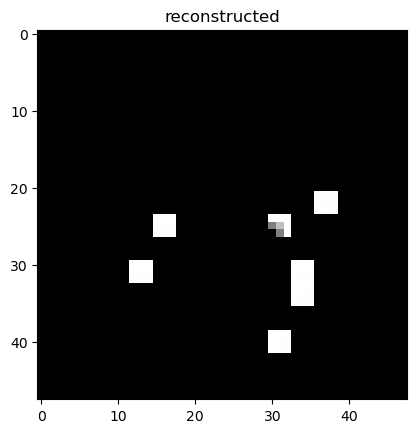

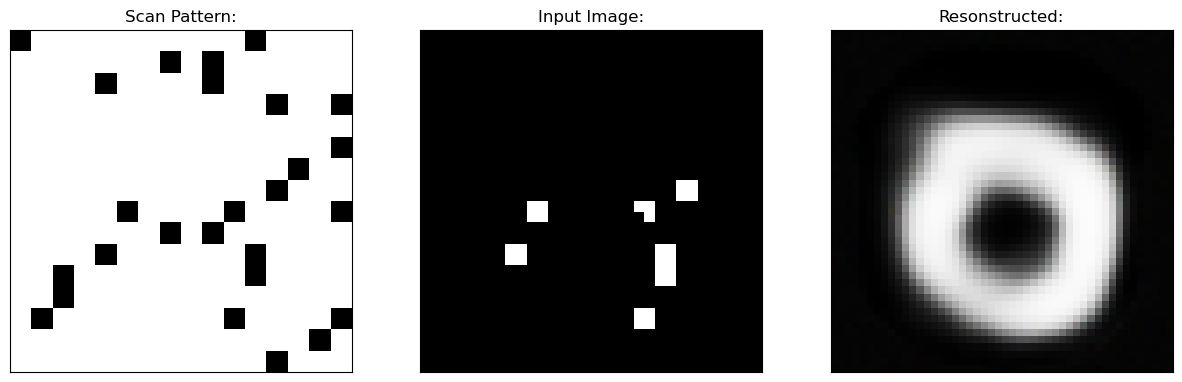

40/40 [==============================] - 6s 145ms/step - loss: 0.0324 - mae: 0.0846
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/Y-90-1-32-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


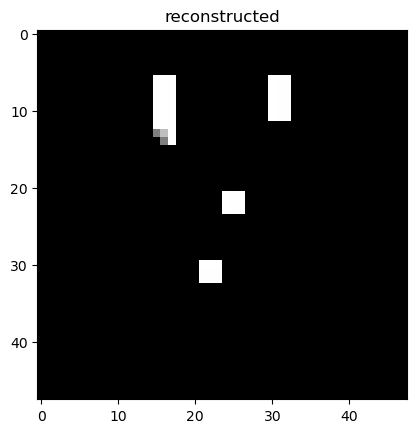

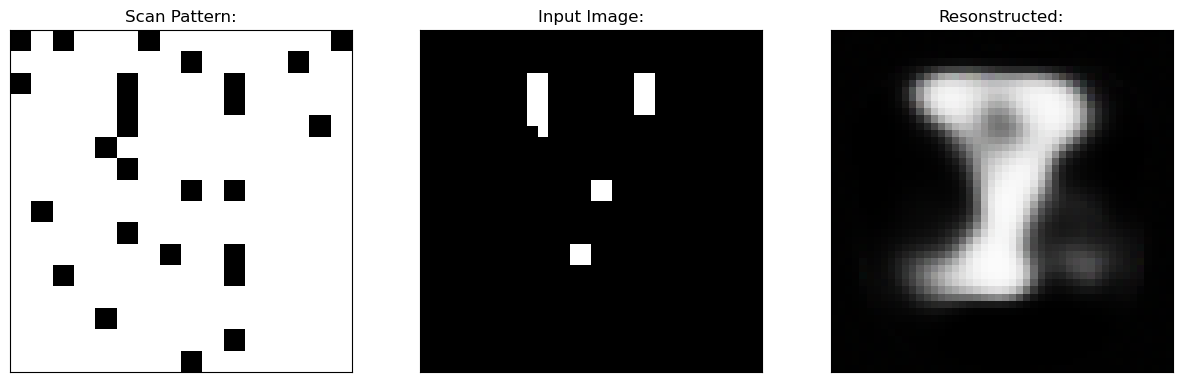

40/40 [==============================] - 6s 144ms/step - loss: 0.0250 - mae: 0.0684
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/0-90-1-6-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


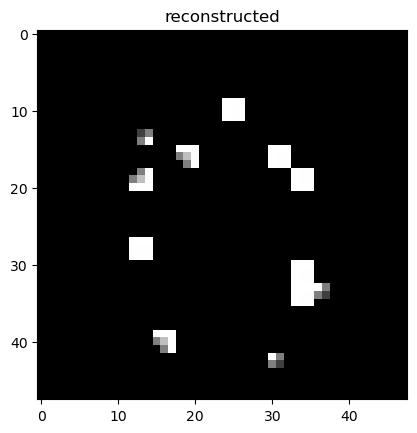

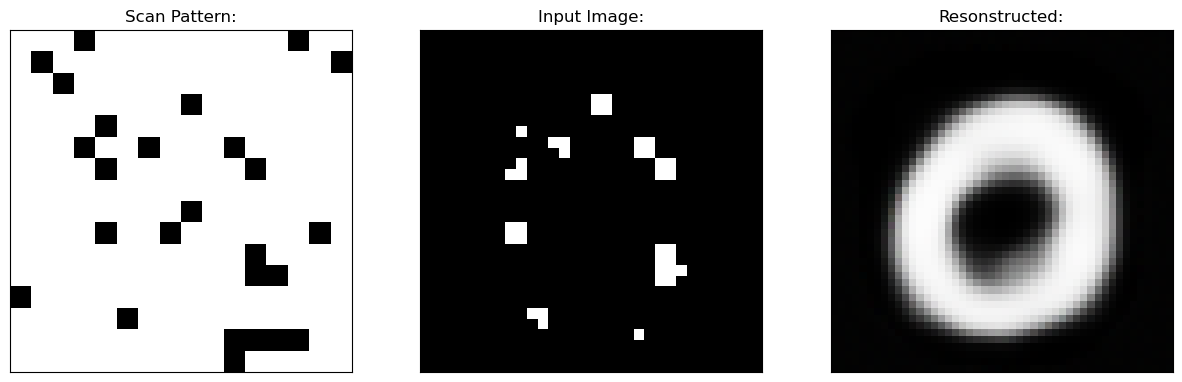

40/40 [==============================] - 6s 144ms/step - loss: 0.0253 - mae: 0.0682
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/S-90-1-2-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


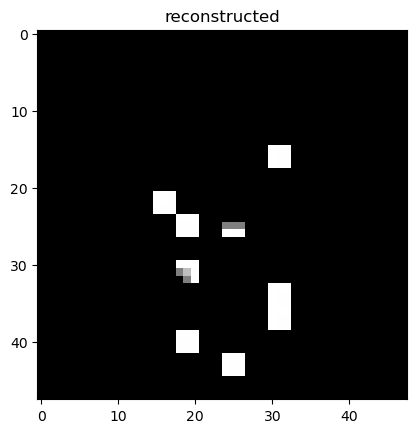

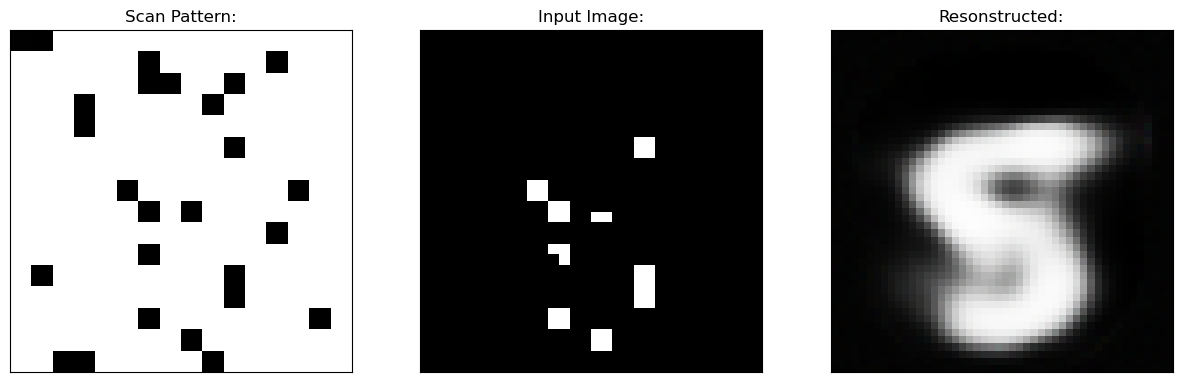

40/40 [==============================] - 6s 144ms/step - loss: 0.0254 - mae: 0.0688
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/T-90-1-40-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


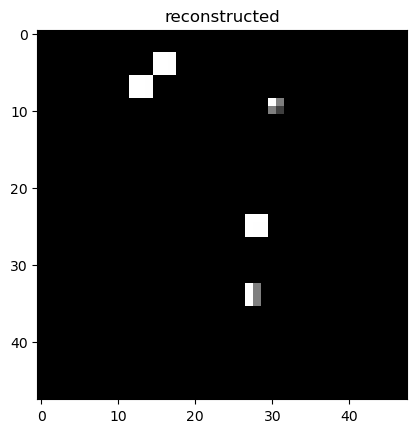

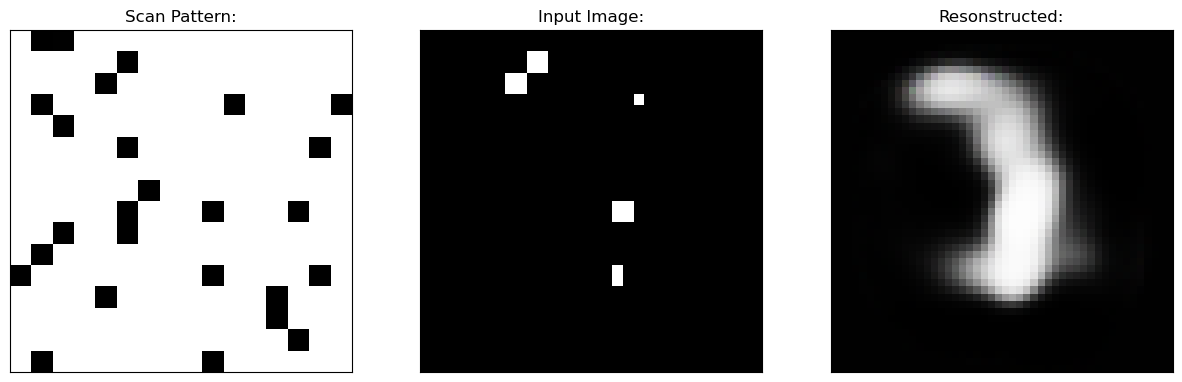

40/40 [==============================] - 6s 146ms/step - loss: 0.0292 - mae: 0.0768
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/N-90-1-19-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


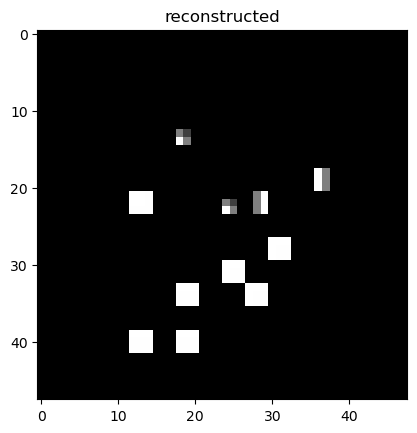

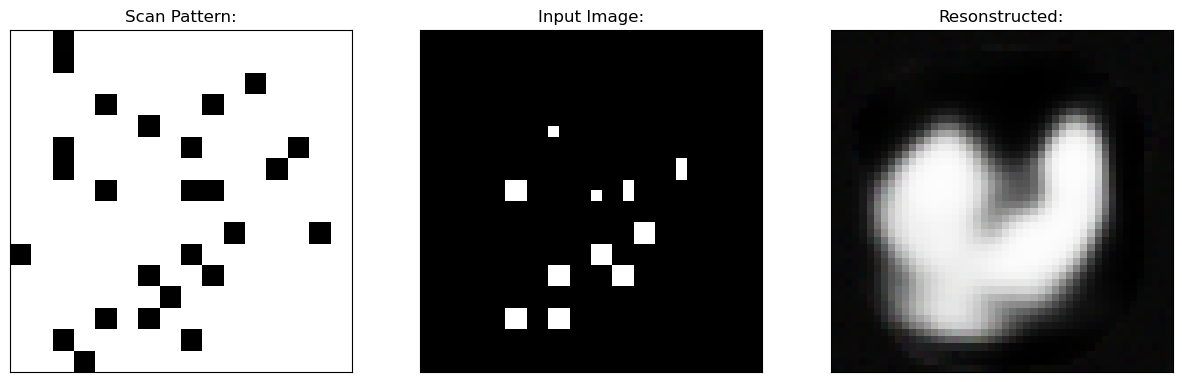

40/40 [==============================] - 6s 146ms/step - loss: 0.0208 - mae: 0.0599
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/U-90-1-9-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


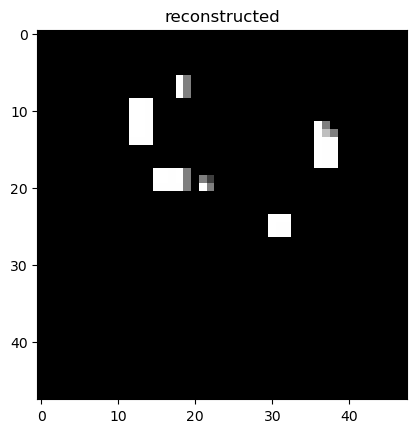

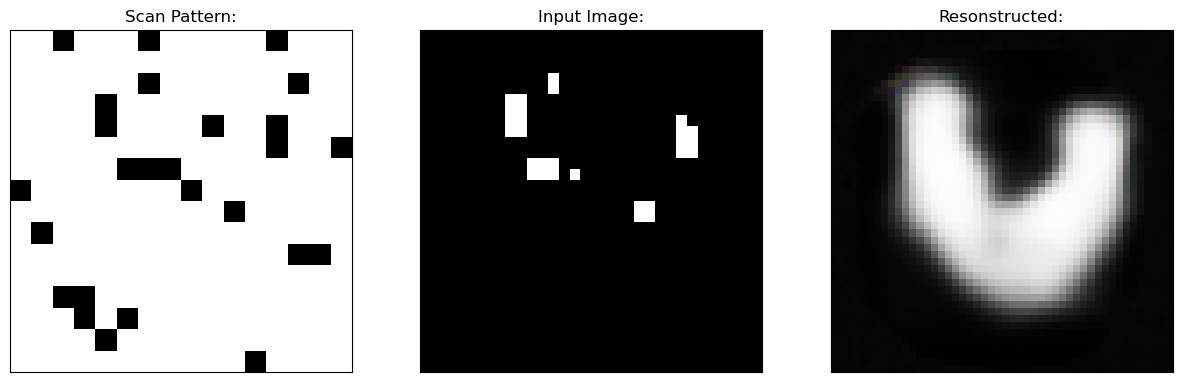

40/40 [==============================] - 6s 144ms/step - loss: 0.0300 - mae: 0.0783
mask_fn /home/ec2-user/SageMaker/Dialate MNIST/MAE/MAE/onPredict/PI-MAE-Scans/PHYSICAL-MASK/90mask-physical/G-90-1-28-plt-mask.png
Changed the PIMAE Callback after training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


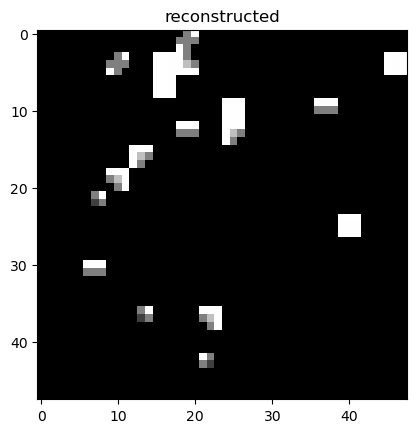

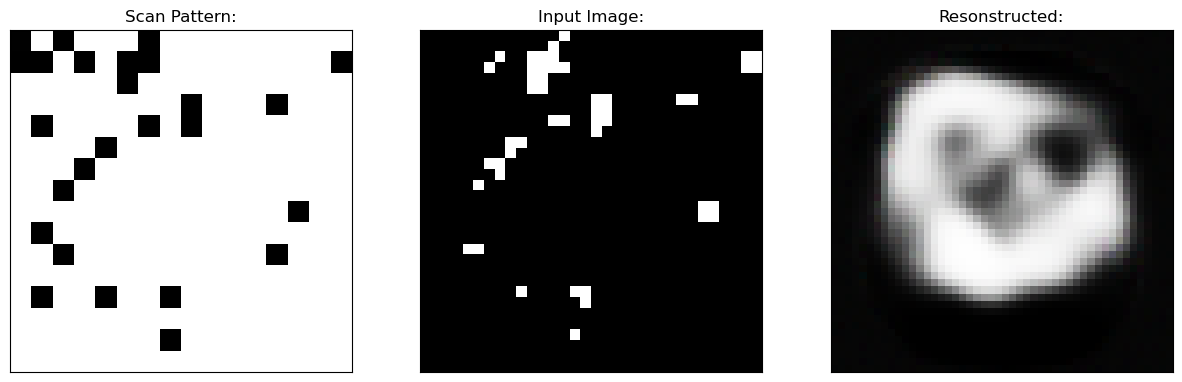

40/40 [==============================] - 6s 144ms/step - loss: 0.0369 - mae: 0.0883


In [25]:
import imageio.v2 as imageio
import numpy as np
import cv2

import os

failed = []

MEMS_Masked_75 = os.path.join(os.getcwd(), 'PI-MAE-Scans/PHYSICAL-MASK/90mask-physical')
Thresh_75 = os.path.join(os.getcwd(), 'PI-MAE-Scans/PHYSICAL-MASK/90mask-physical')

for file in os.listdir(Thresh_75):

    if (file[-3:] == 'png') and ('cv2' not in file):
        continue
    fig_fn = file
    img_fn = os.path.join(Thresh_75, file)
    img = cv.imread(img_fn, cv.IMREAD_GRAYSCALE)
    if img is None:
        failed.append(file)
        continue
    obj, mask_percent, _, idx, _ = fig_fn.split('-')
    mask_fn = f'{obj}-{mask_percent}-1-{idx}-plt-mask.png'
    mask_fn = os.path.join(MEMS_Masked_75, mask_fn)
    print('mask_fn', mask_fn)
    img_mask = cv.imread(mask_fn, cv.IMREAD_GRAYSCALE)
    if img_mask is None:
        failed.append(file)
        continue

    arr = img

    if arr.shape[1] == 32:
        arr = rescale_image(arr)

    patch_encoder.tmp_x = img_mask
    patch_encoder.setMasking = True

    x_ingas = np.array([arr])
    y_ingas = np.array([0])

    x_ingas = np.expand_dims(x_ingas, -1)
    y_ingas = np.expand_dims(y_ingas, -1)

    x_ingas = tf.image.grayscale_to_rgb(
        tf.convert_to_tensor(x_ingas),
        name=None
    )

    ingas_ds = tf.data.Dataset.from_tensor_slices(x_ingas)
    ingas_ds = ingas_ds.batch(BATCH_SIZE).prefetch(AUTO)

    x_ingas_ds = tf.data.Dataset.from_tensor_slices(x_ingas)
    x_ingas_ds = ingas_ds.batch(BATCH_SIZE).prefetch(AUTO)

    test_images = next(iter(ingas_ds))

    try:
        pimae_model.evaluate(test_ds, callbacks=[PIMAEBlockCustomCallback()])
    except:
        print('failed')
        failed.append(file)